In [1]:
import shap
import xgboost
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

from src.utils import get_project_root
from src.evaluation.scoring import wmape, wbias
from src.data.splitting import split_dataset, time_series_cv

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [51]:
## Functions

def forecast_bias(actual: pd.Series, forecast: pd.Series):
    return round(((forecast - actual).sum()/len(actual))*100, 2)

# Configuration

In [9]:
# Model
MODELS_FOLDER = get_project_root() / 'models'
MODEL_PATH = MODELS_FOLDER / 'xgb_caffe_bar_demand_forecast_v1.bst'
# Datasets
DATASETS_FOLDER = get_project_root() / 'data/processed'
TRAIN_DATASET_PATH = DATASETS_FOLDER / 'train_data.pkl'
VALID_DATASET_PATH = DATASETS_FOLDER / 'valid_data.pkl'
TEST_DATASET_PATH = DATASETS_FOLDER / 'test_data.pkl'
# Target
TARGET = 'sales_qty'

# Load model

In [35]:
booster = xgboost.Booster()
booster.load_model(MODEL_PATH)
if booster.attr('feature_names') is not None: 
    booster.feature_names = booster.attr('feature_names').split('|')

# Load datasets

In [10]:
train_dataset = pd.read_pickle(TRAIN_DATASET_PATH)  
valid_dataset = pd.read_pickle(VALID_DATASET_PATH)  
test_dataset = pd.read_pickle(TEST_DATASET_PATH)  

In [39]:
train_dataset.loc[:, 'sample'] = 'train'
valid_dataset.loc[:, 'sample'] = 'valid'
test_dataset.loc[:, 'sample'] = 'test'

In [43]:
dataset = pd.concat([train_dataset, valid_dataset, test_dataset])

In [48]:
train_mask = (dataset['sample'] == 'train')
valid_mask = (dataset['sample'] == 'valid')
test_mask = (dataset['sample'] == 'test')

# Predict

In [44]:
dataset.loc[:, 'prediction'] = booster.predict(xgboost.DMatrix(dataset[booster.feature_names]), iteration_range = (0, booster.best_iteration))
dataset.loc[:, 'error_diff'] = dataset['prediction'] - dataset['sales_qty']
dataset.loc[:, 'abs_diff'] = np.abs(dataset['prediction'] - dataset['sales_qty'])

# Evaluation

## Total metrics

In [54]:
ds = {
    'Train': train_mask,
    'Valid': valid_mask,
    'Test': test_mask
}

for ds, mask in ds.items():
    print(f"{ds} WMAPE:", wmape(dataset[mask]['sales_qty'], dataset[mask]['prediction']))
    print(f"{ds} WBias:", wbias(dataset[mask]['sales_qty'], dataset[mask]['prediction']))
    print(f"{ds} forecast bias:", bias(dataset[mask]['sales_qty'], dataset[mask]['prediction']))

Train WMAPE: 42.47
Train WBias: -0.01
Train forecast bias: -0.04
Valid WMAPE: 44.82
Valid WBias: 1.37
Valid forecast bias: 8.66
Test WMAPE: 44.2
Test WBias: -0.57
Test forecast bias: -3.89


## Feature importances

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


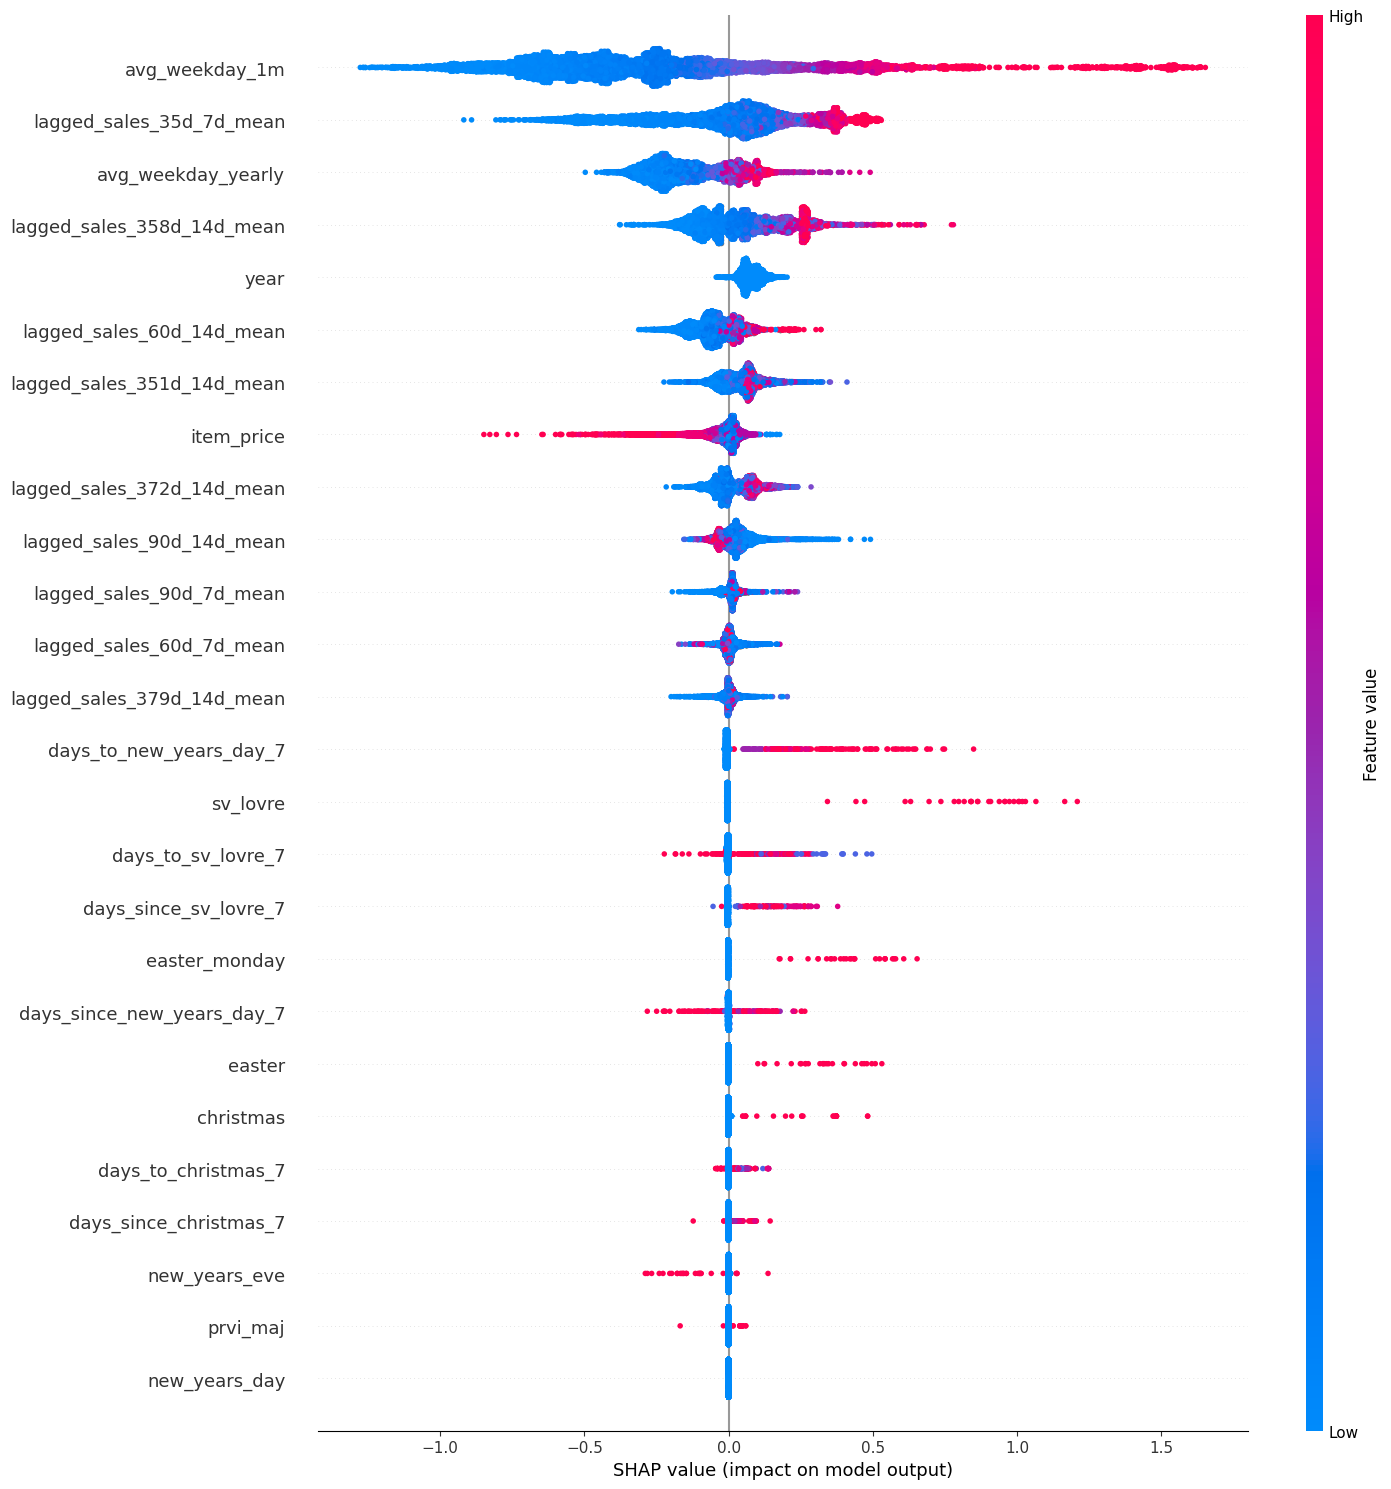

In [58]:
subsample_size = 10000

explainer = shap.TreeExplainer(booster)
predictors = booster.feature_names

df_sample = dataset[valid_mask][predictors].sample(subsample_size)

shap_values = explainer(df_sample)

shap.summary_plot(shap_values.values, df_sample, max_display=60, show=True, plot_size=[15,15])
plt.show()

## Visualisation of scores

In [61]:

wmape_train_valid_scores = dataset[train_mask | valid_mask].groupby('item_name').apply(lambda x: pd.Series({'bias': wbias(x['sales_qty'], x['prediction']), 
                                                                'wmape': wmape(x['sales_qty'], x['prediction']),
                                                               'total_sales': x['sales_qty'].sum(),
                                                               'total_prediction': x['prediction'].sum()})
                                                                ).sort_values(by='total_sales', ascending=False).reset_index()
wmape_test_scores = dataset[test_mask].groupby('item_name').apply(lambda x: pd.Series({'bias': wbias(x['sales_qty'], x['prediction']), 
                                                                'wmape': wmape(x['sales_qty'], x['prediction']),
                                                                'total_sales': x['sales_qty'].sum(),
                                                                'total_prediction': x['prediction'].sum()})
                                                                ).sort_values(by='total_sales', ascending=False).reset_index()

(0.0, 186.76850000000002)

Glyph 154 (\x9a) missing from current font.
Glyph 158 (\x9e) missing from current font.
Glyph 154 (\x9a) missing from current font.
Glyph 158 (\x9e) missing from current font.


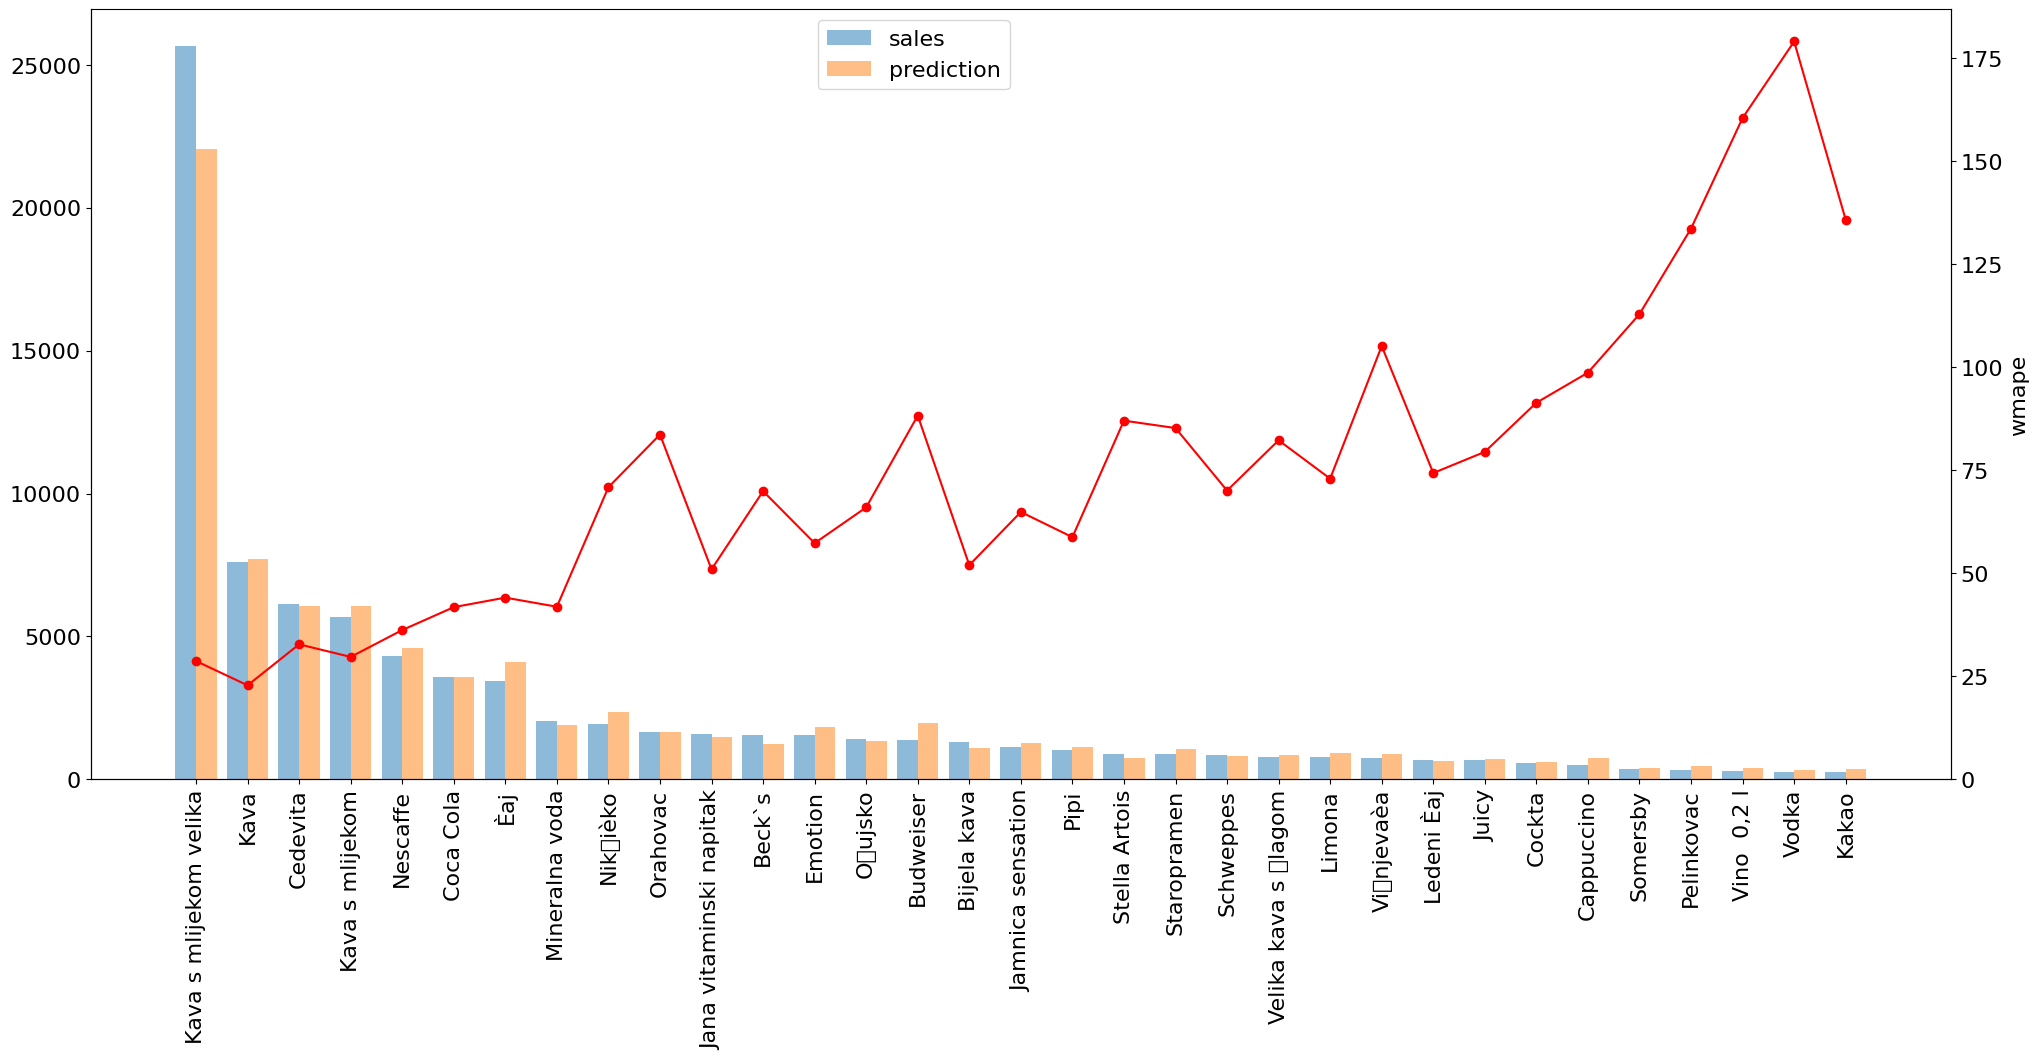

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(24,10))

X_axis = np.arange(len(wmape_test_scores['item_name']))
p1 = ax.bar(X_axis - 0.2, wmape_test_scores['total_sales'], width=0.4, alpha=0.5, label='sales')
p2 = ax.bar(X_axis + 0.2, wmape_test_scores['total_prediction'], width=0.4, alpha=0.5, label='prediction')
ax.spines['top'].set_visible(False)
ax.set_xticks(X_axis)
ax.set_xticklabels(wmape_test_scores['item_name'], rotation=90, fontsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.legend(bbox_to_anchor=(0.5, 1), fontsize=16)

ax2 = ax.twinx()
p3 = ax2.plot(X_axis, wmape_test_scores['wmape'], color = 'red', marker='o', label='wmape')
ax2.set_ylabel('wmape', fontsize=16)
ax2.tick_params(axis='y', labelsize=16)
ax2.set_ylim([0, ax2.get_ylim()[1]])


In [64]:
## Examples with highest sales in train set

In [ ]:
## Examples with best WMAPE 

In [ ]:
## Examples with worst WMAPE

In [ ]:
## Example with least bias

#### Item: Kava s mlijekom velika ####
## Train & valid scores: 
WMAPE: 19.95
Bias: -2.75
## Test scores: 
WMAPE: 28.68
Bias: -14.09


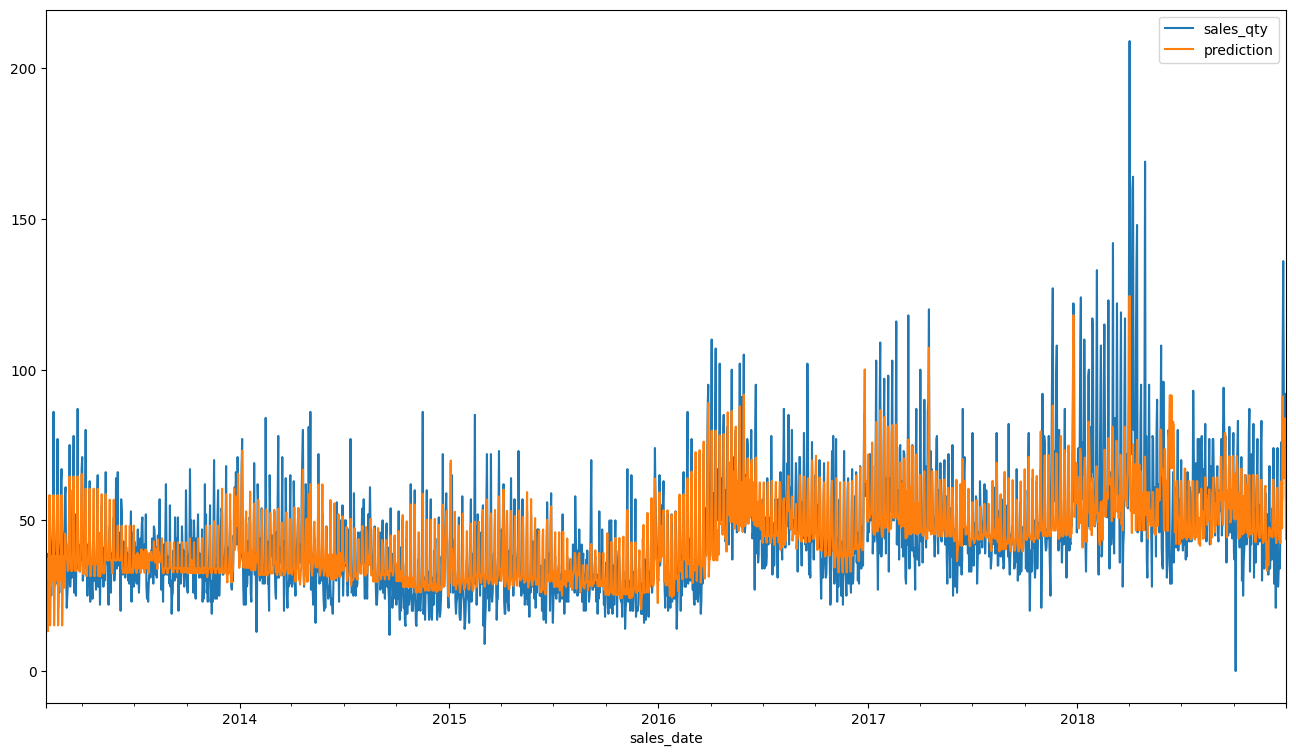

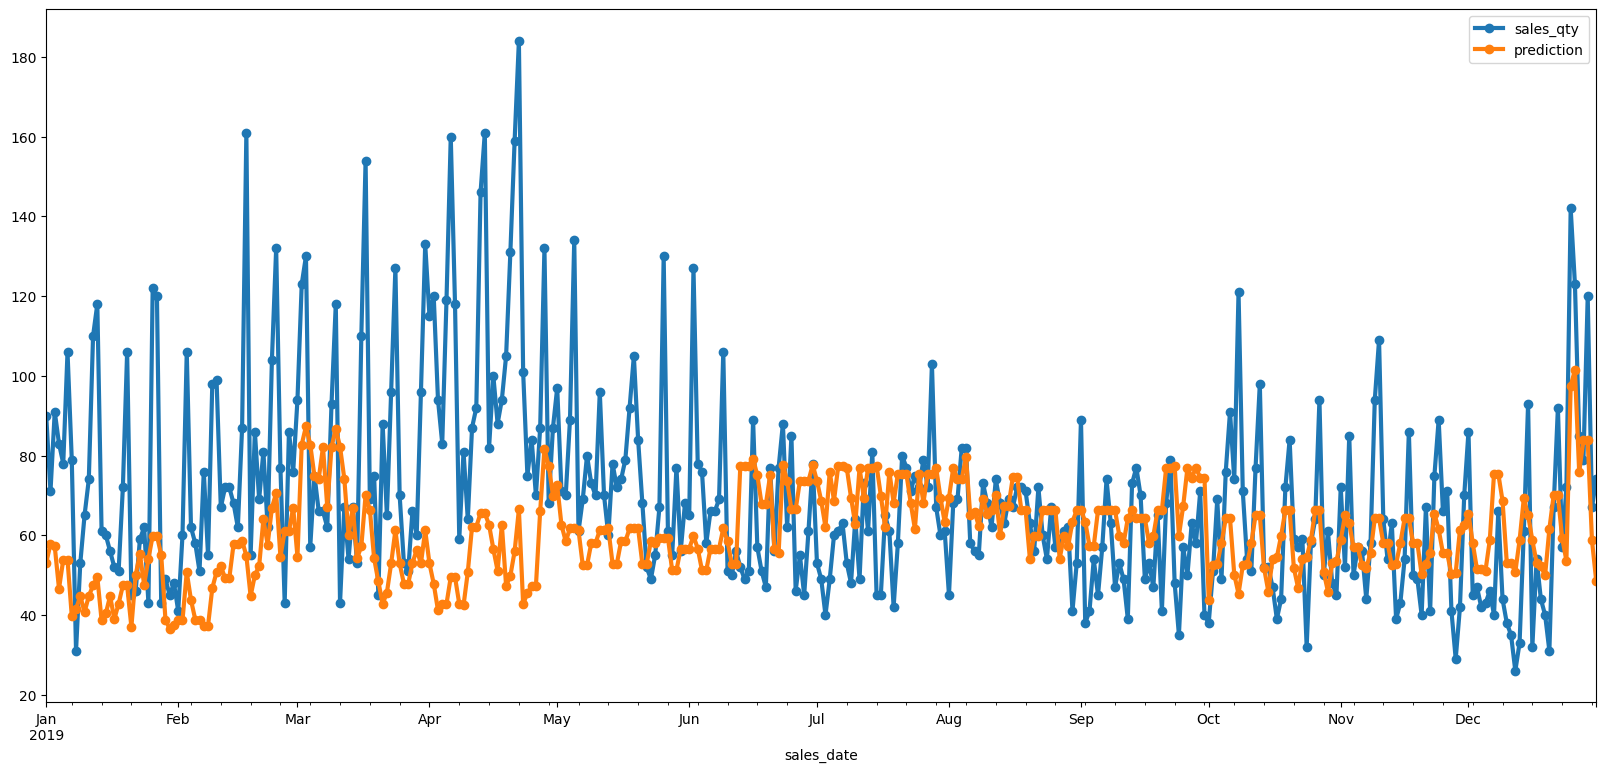

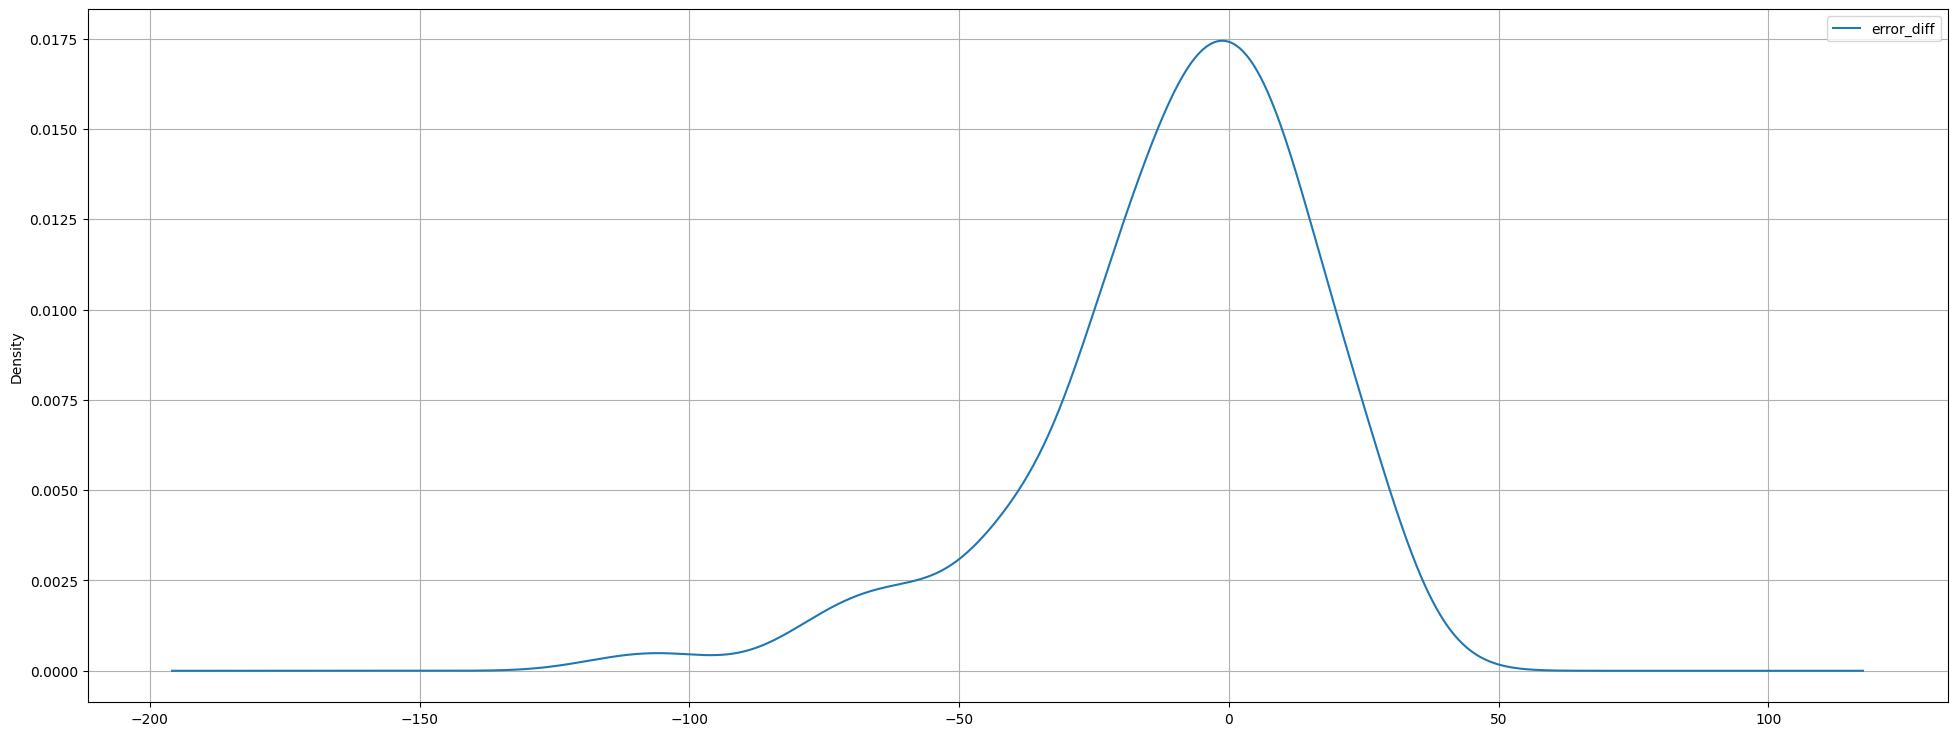

#### Item: Kava ####
## Train & valid scores: 
WMAPE: 26.08
Bias: 0.86
## Test scores: 
WMAPE: 22.79
Bias: 1.07


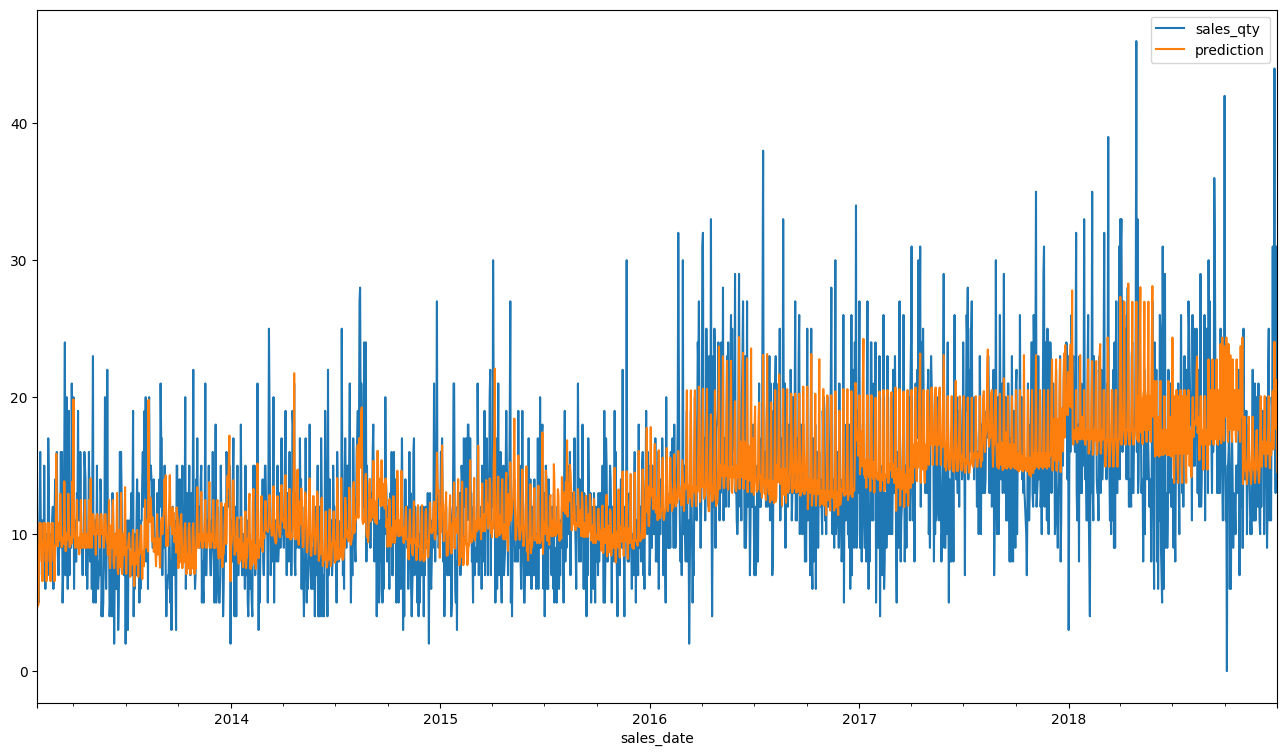

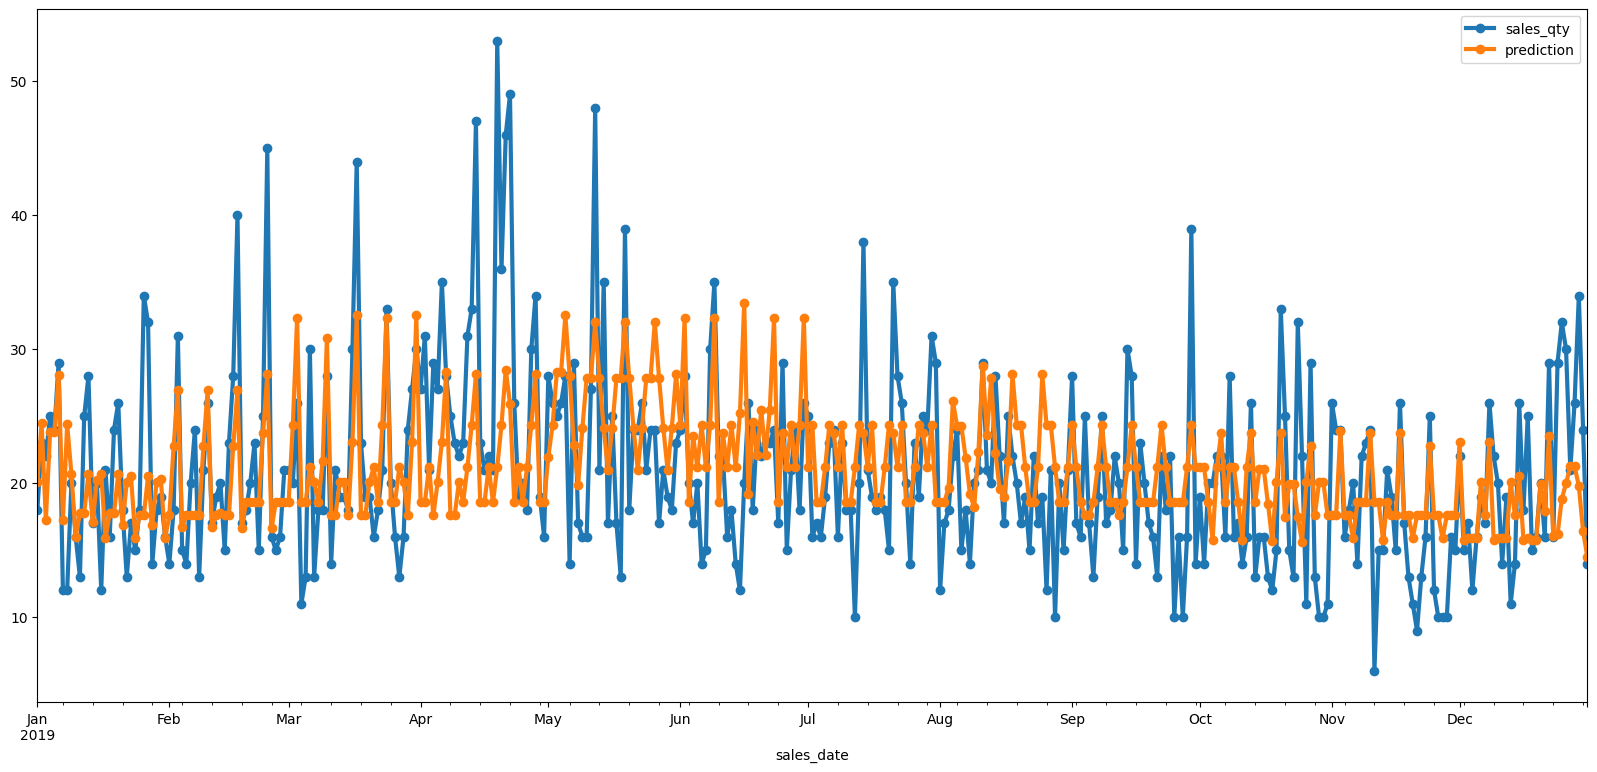

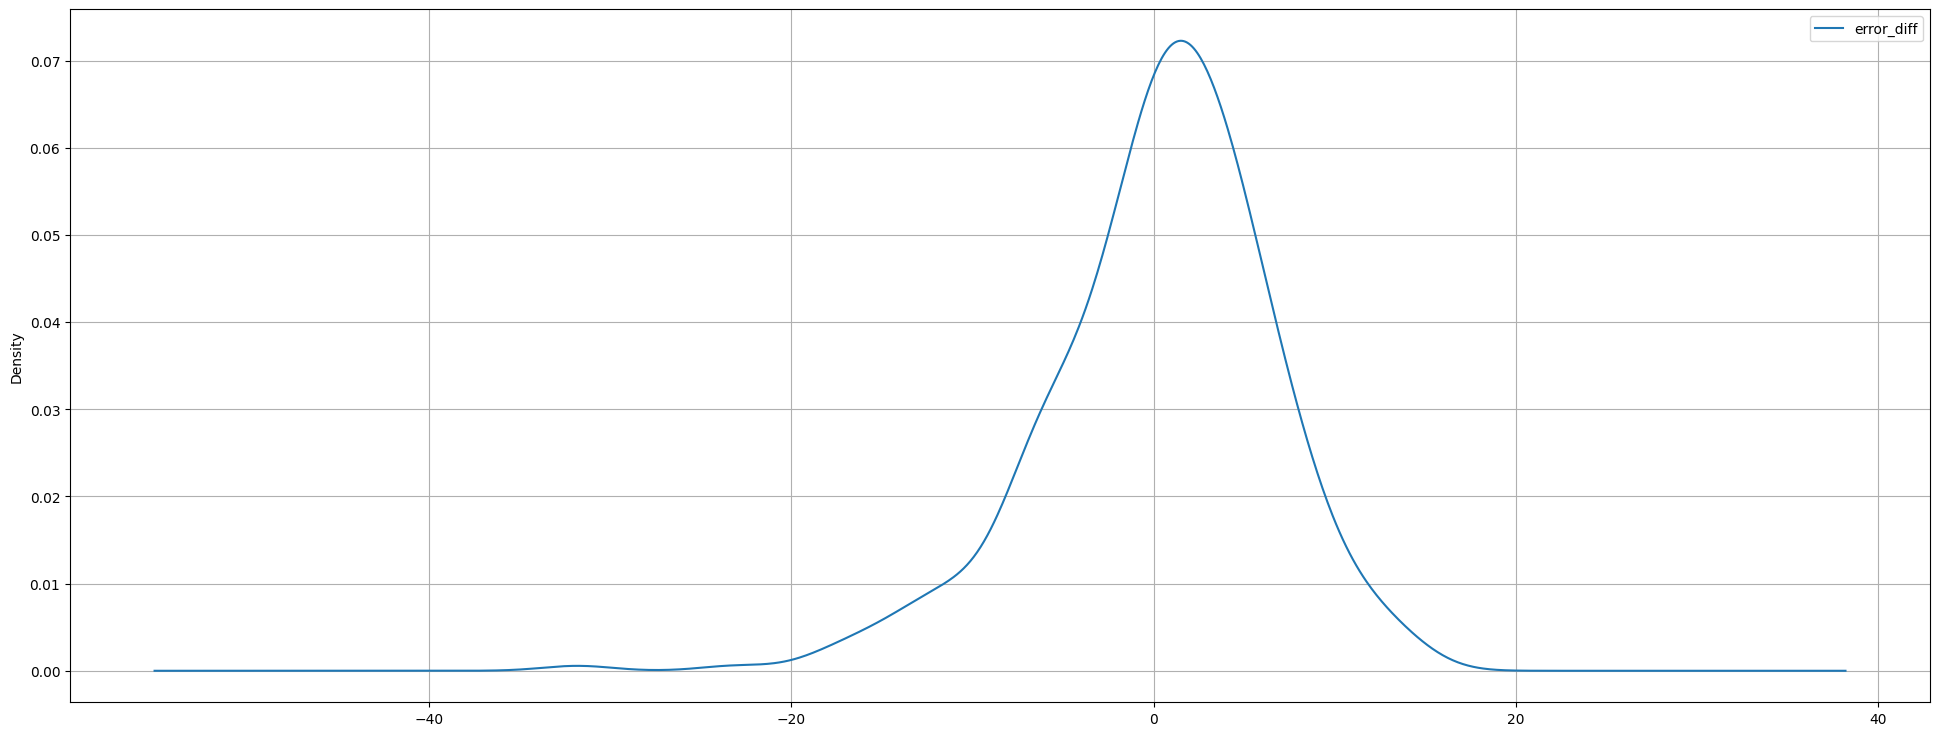

#### Item: Cedevita ####
## Train & valid scores: 
WMAPE: 34.68
Bias: -4.56
## Test scores: 
WMAPE: 32.73
Bias: -1.25


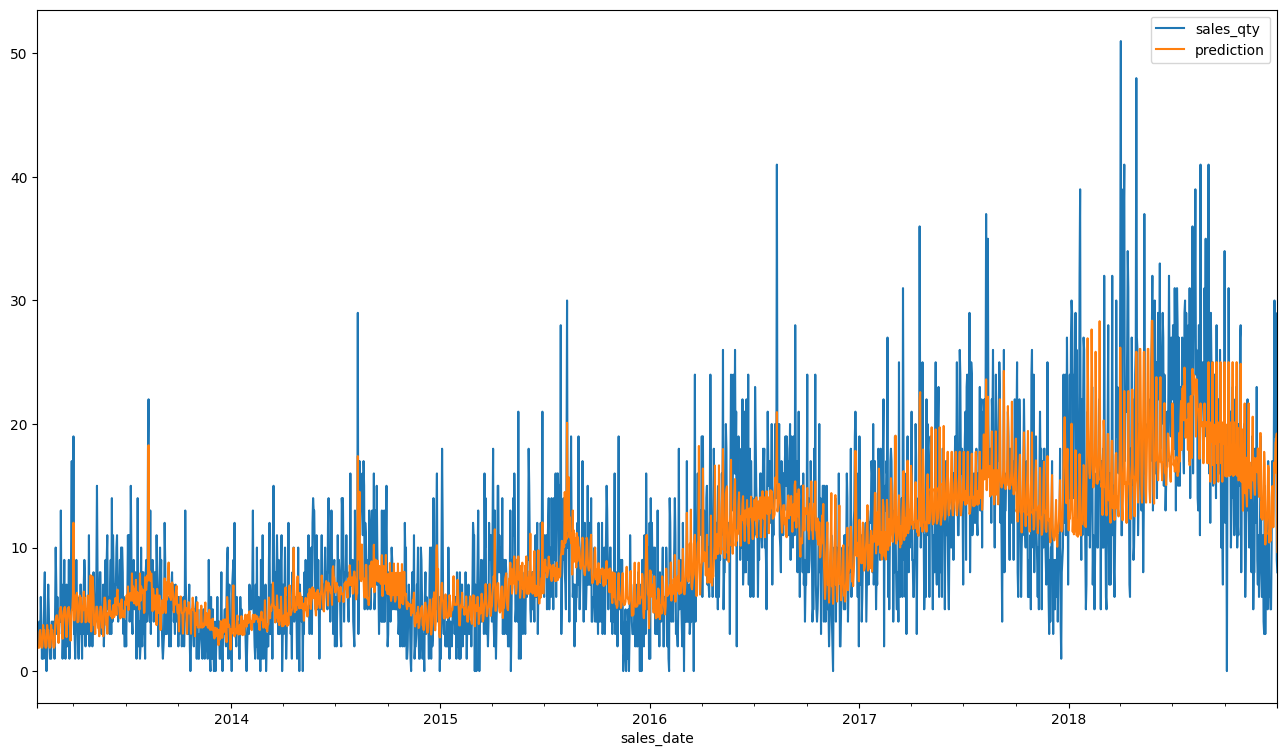

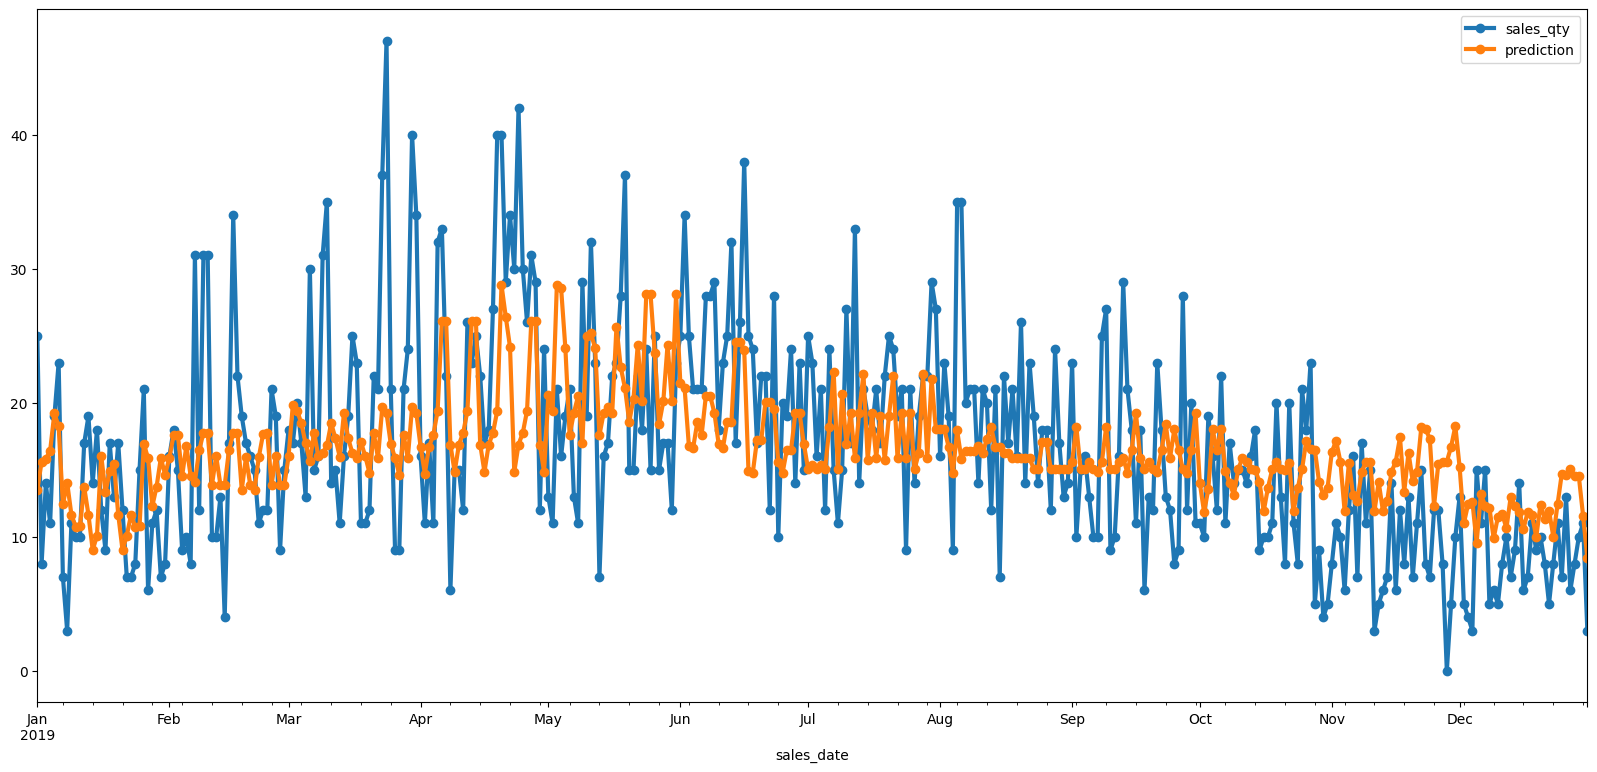

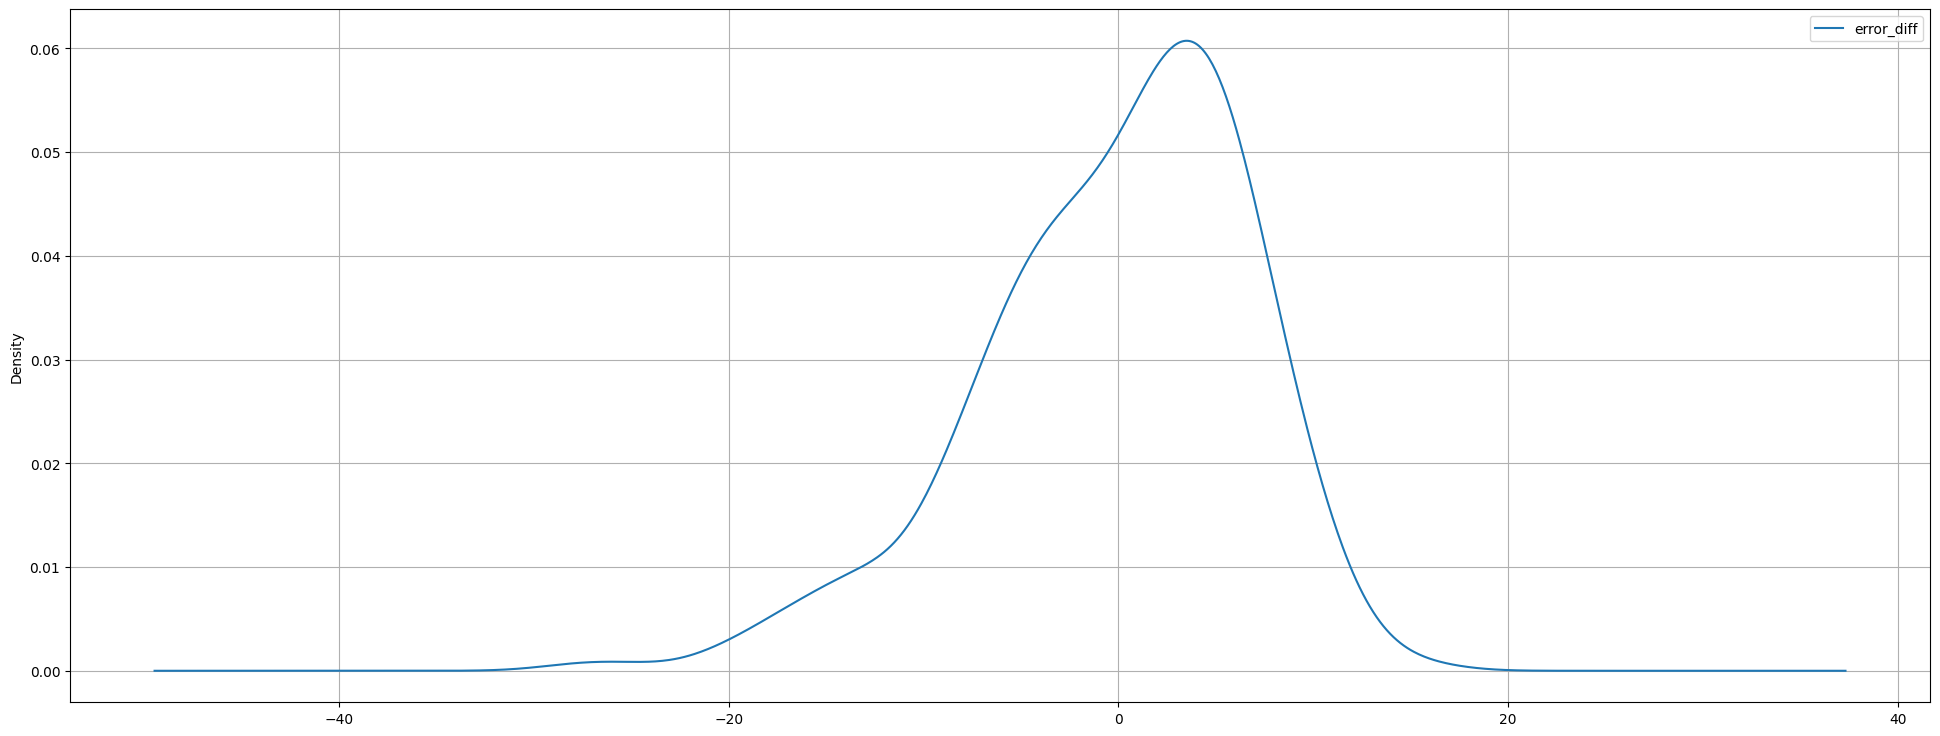

#### Item: Nescaffe ####
## Train & valid scores: 
WMAPE: 34.0
Bias: 0.39
## Test scores: 
WMAPE: 36.19
Bias: 6.43


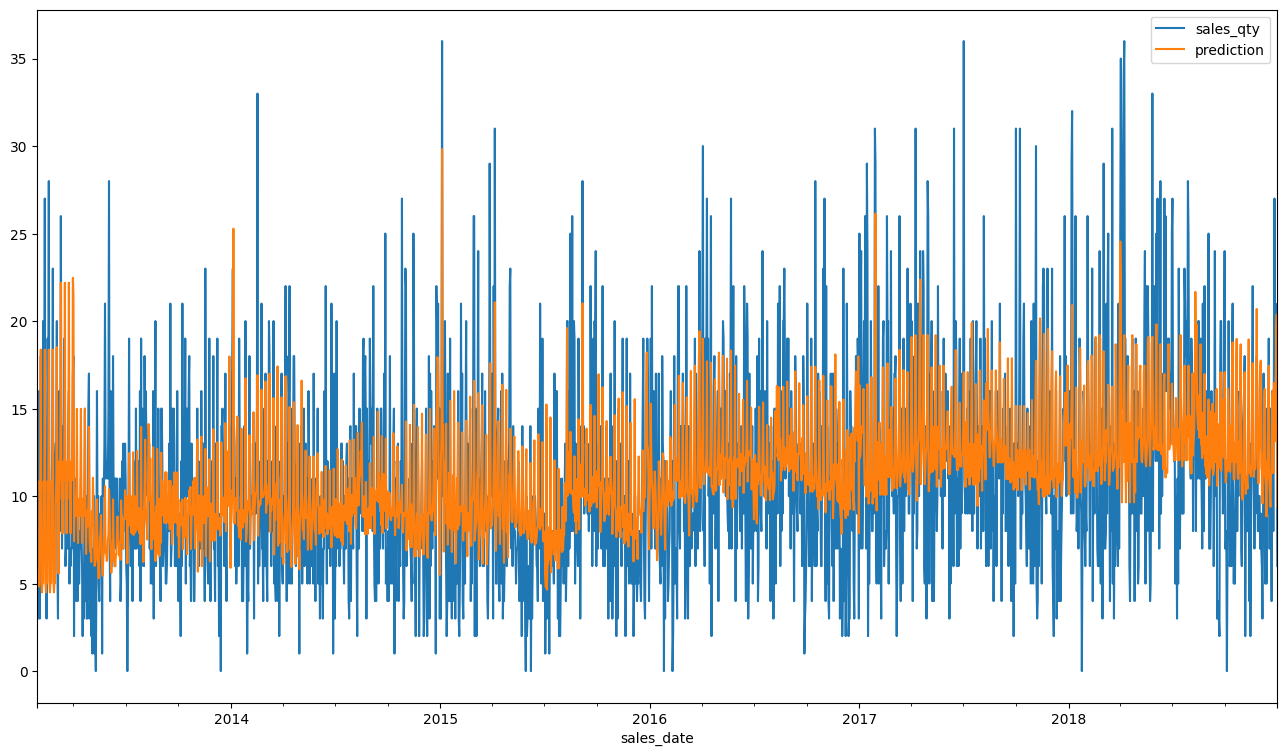

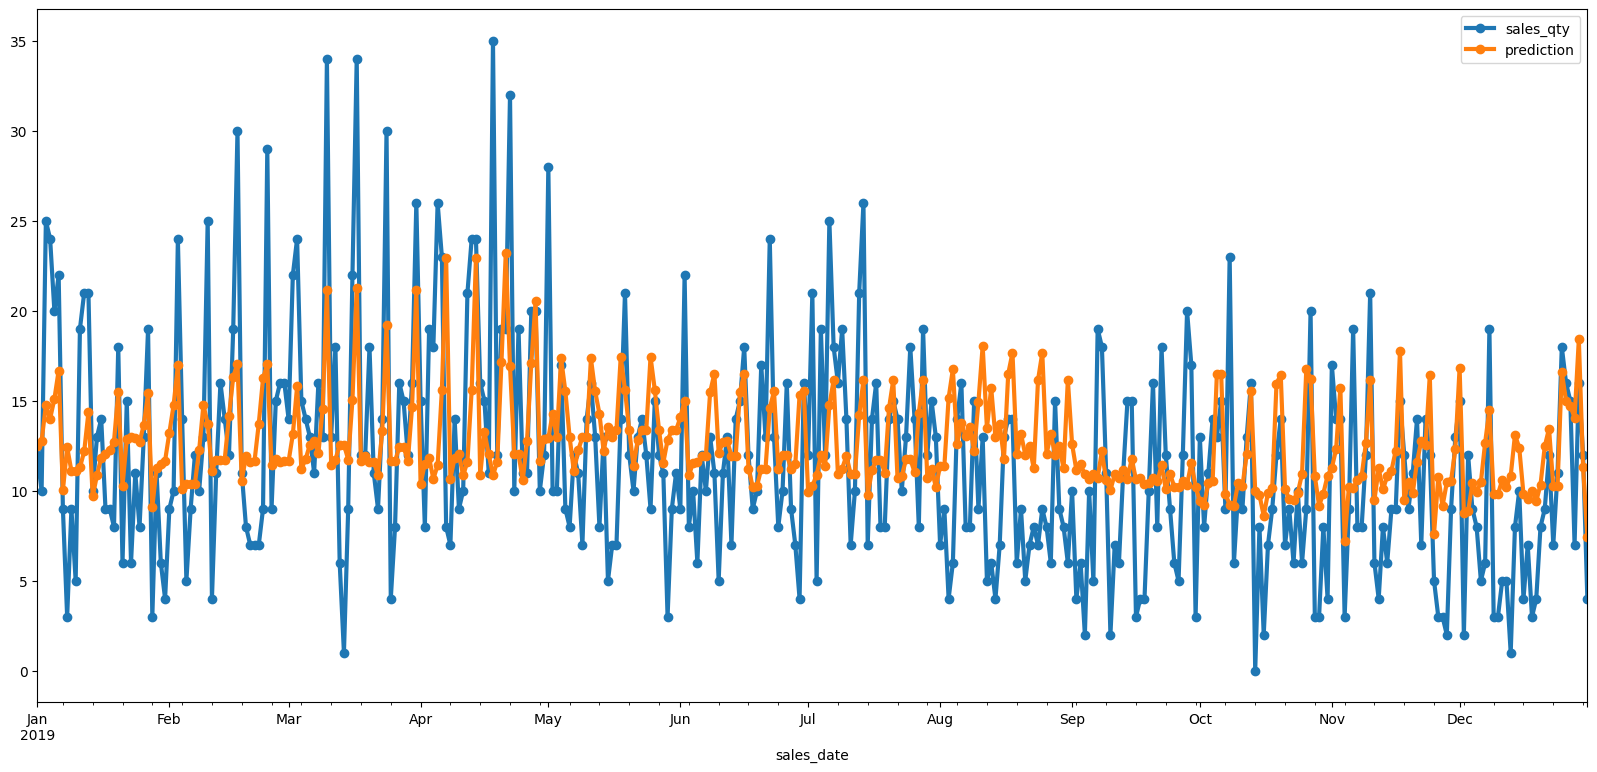

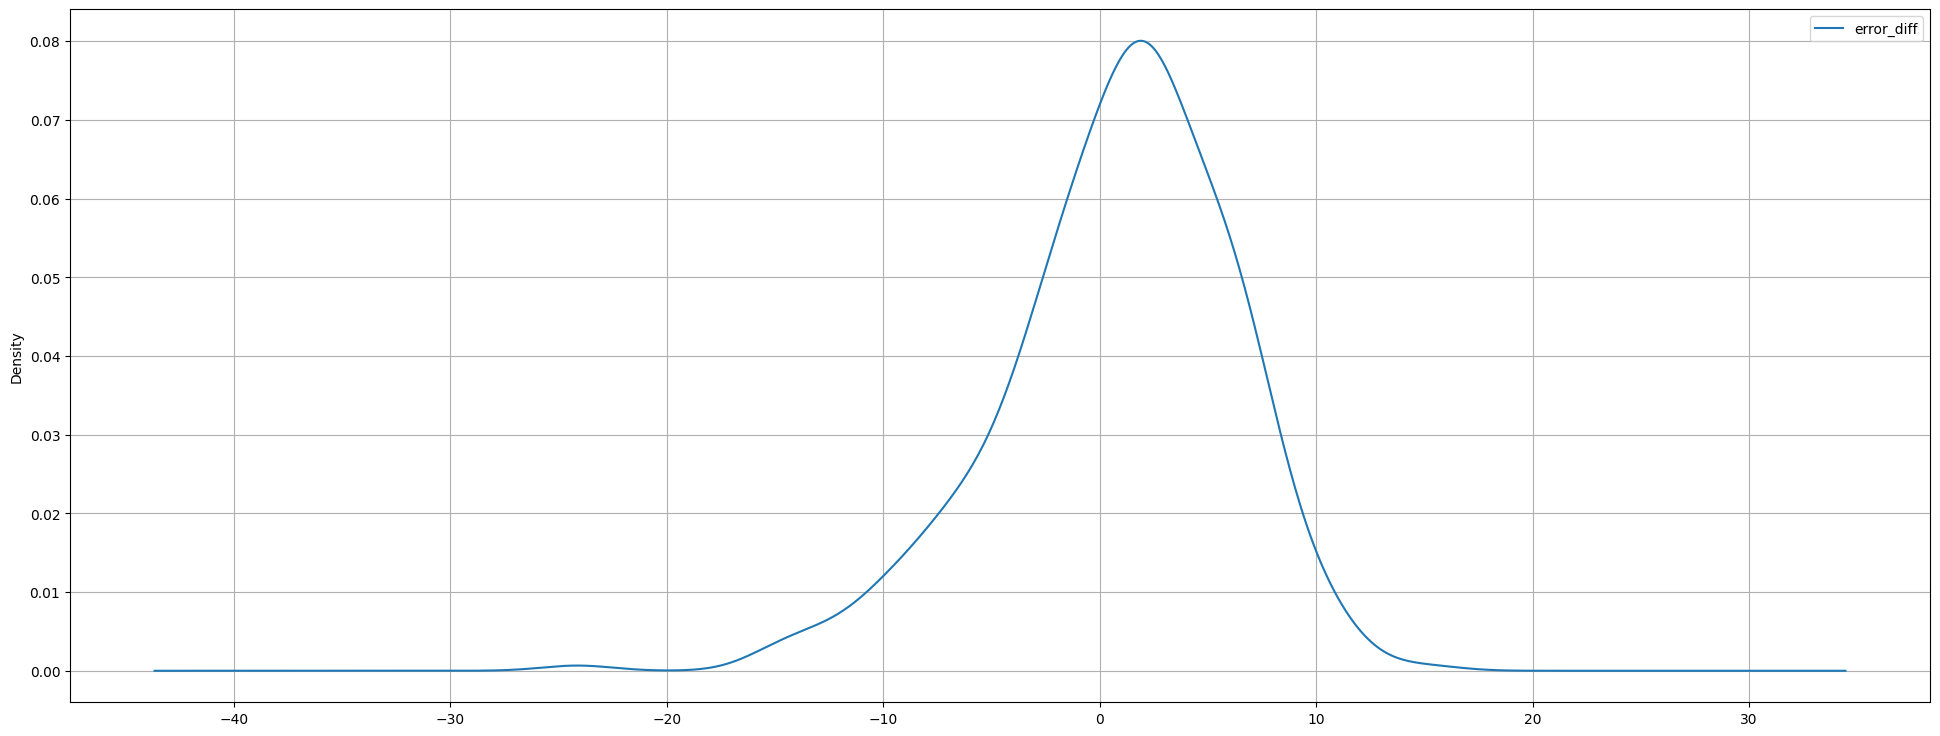

#### Item: Kava s mlijekom ####
## Train & valid scores: 
WMAPE: 33.06
Bias: 3.31
## Test scores: 
WMAPE: 29.68
Bias: 6.98


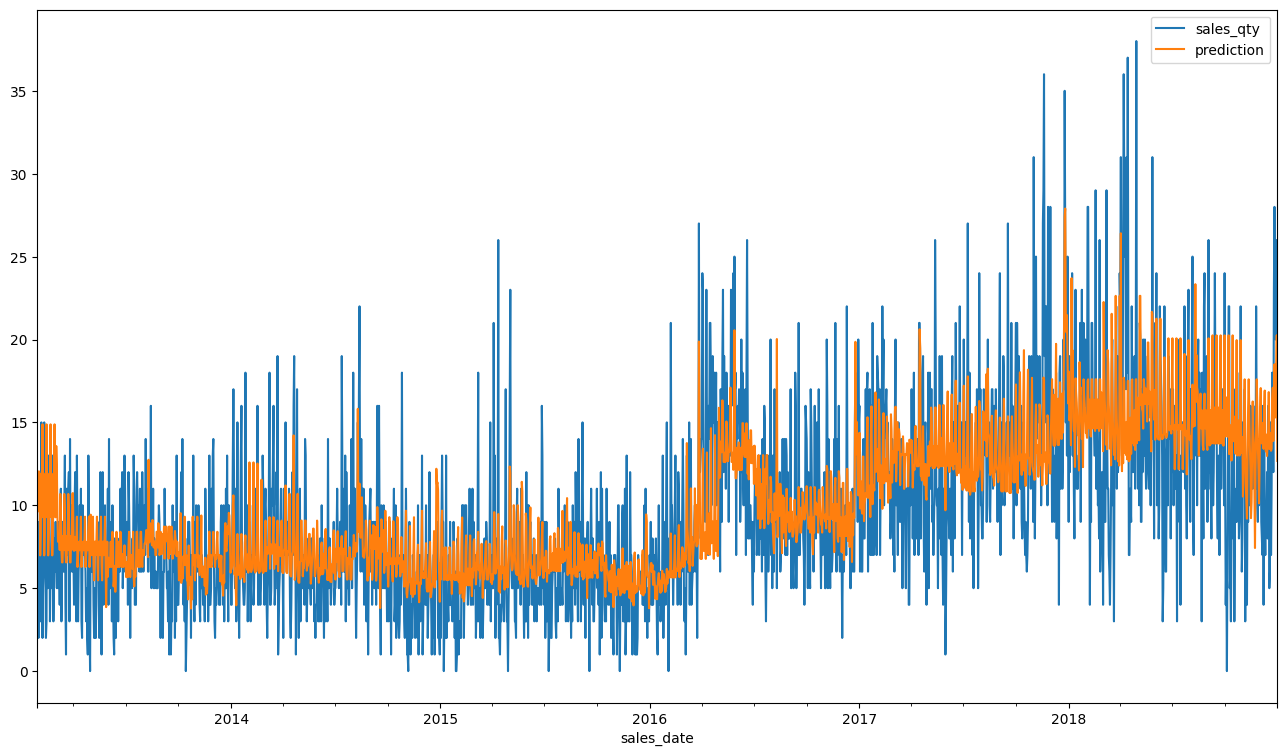

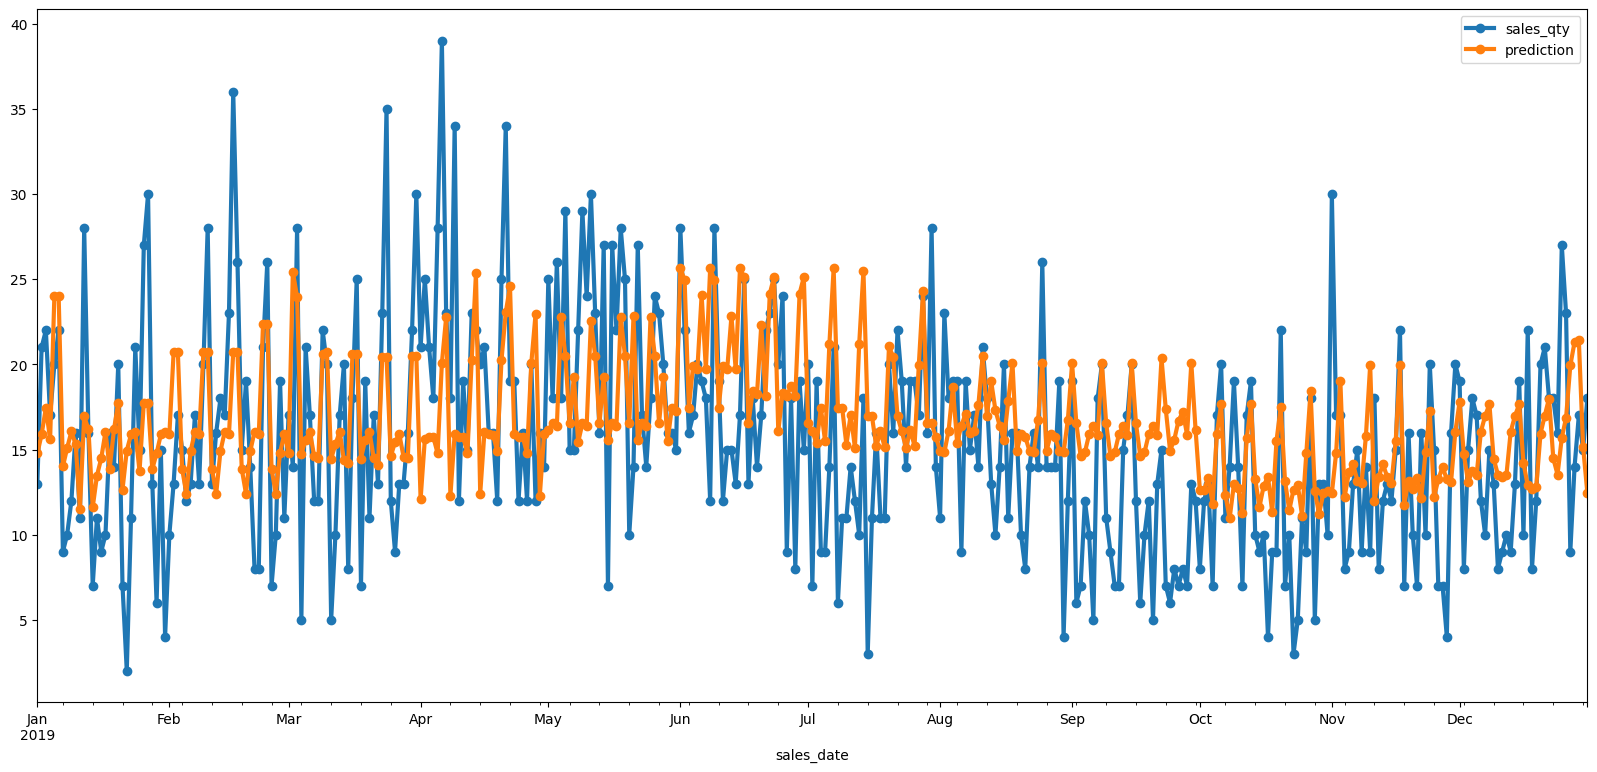

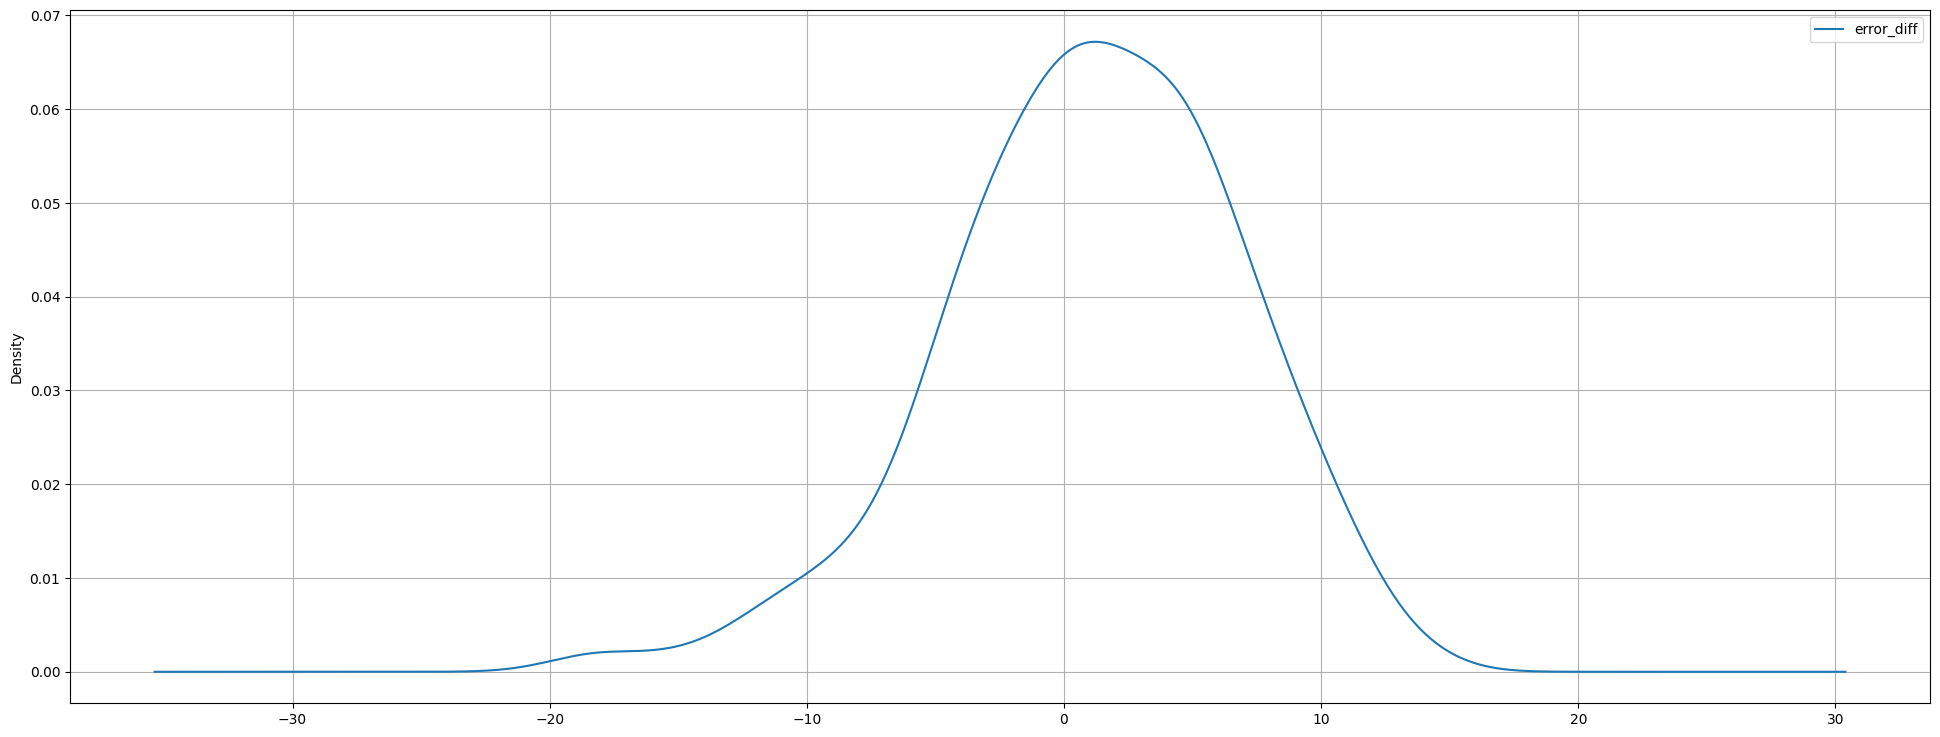

#### Item: Coca Cola ####
## Train & valid scores: 
WMAPE: 51.41
Bias: -1.66
## Test scores: 
WMAPE: 41.75
Bias: 0.78


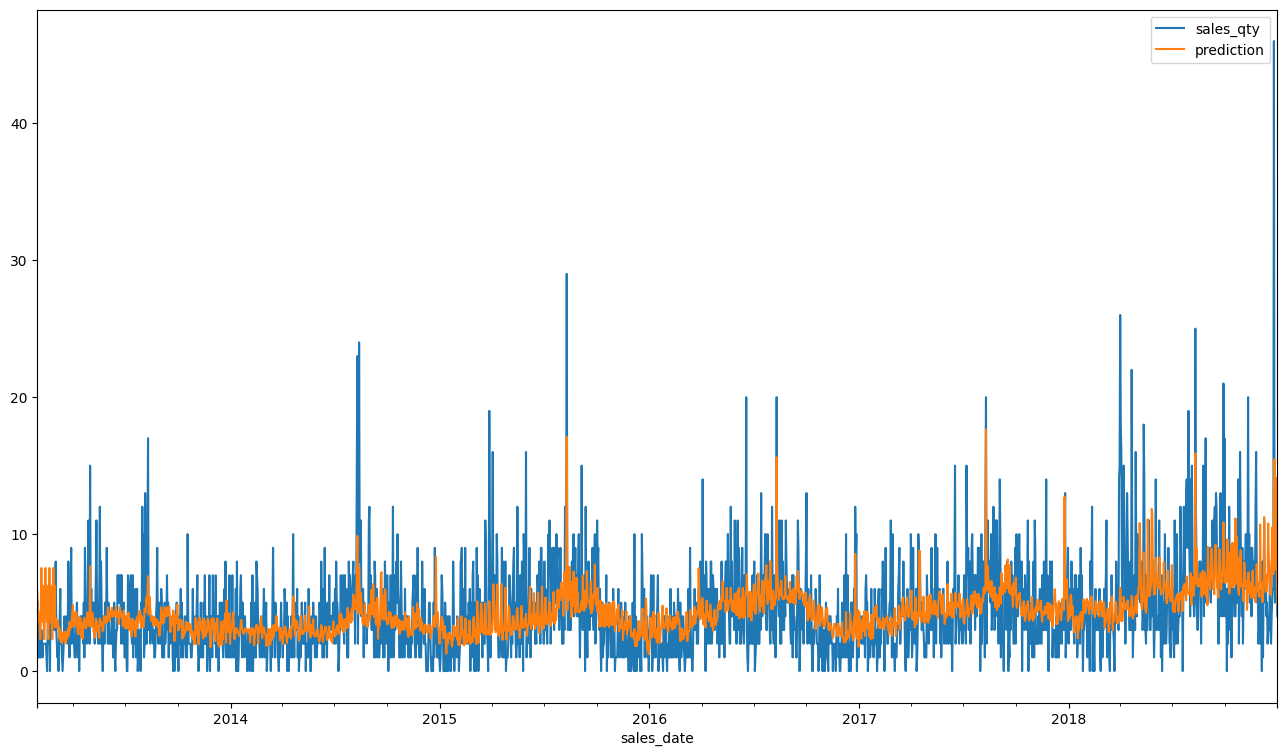

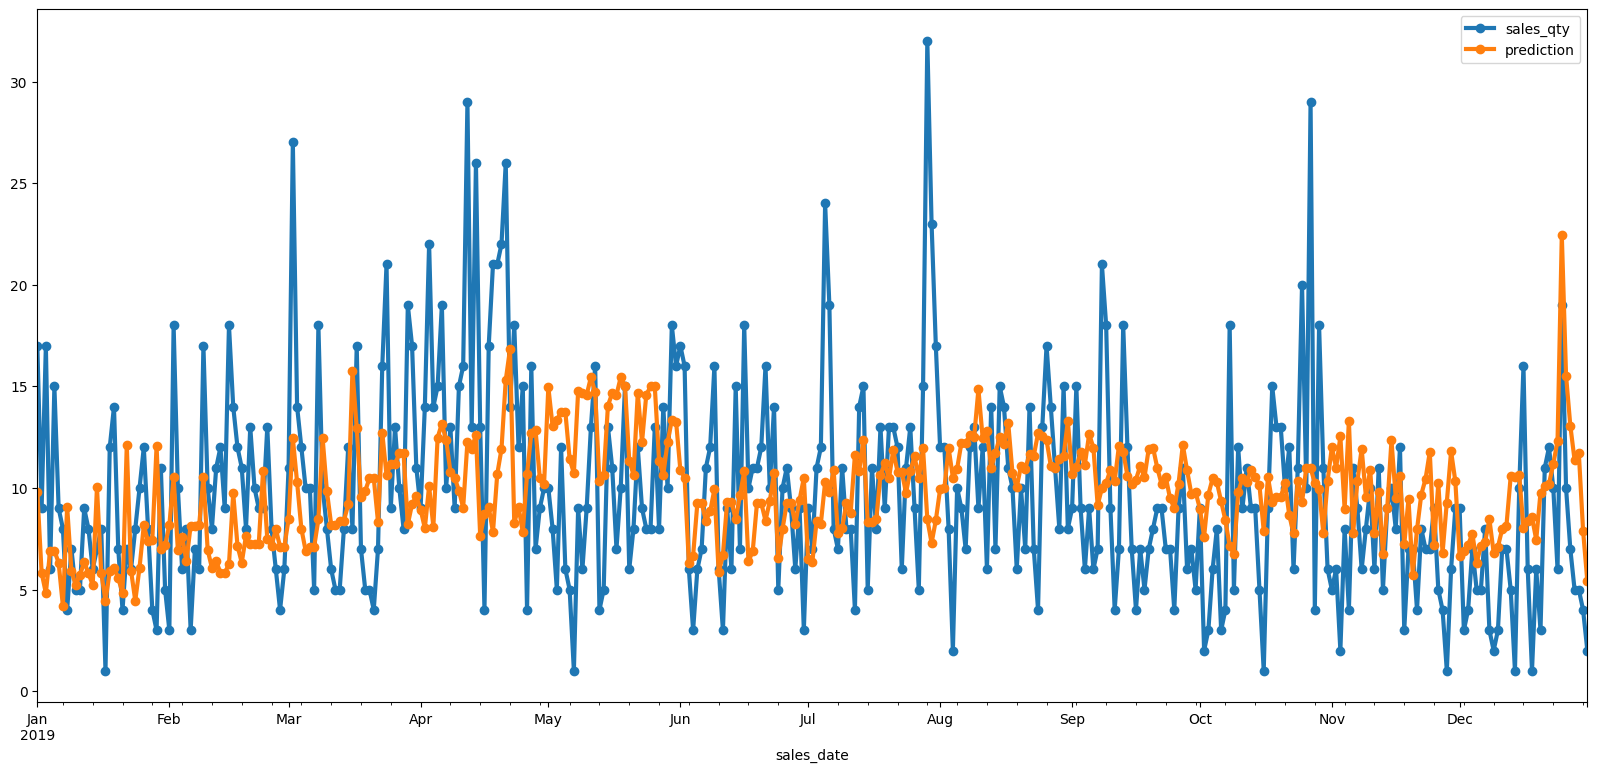

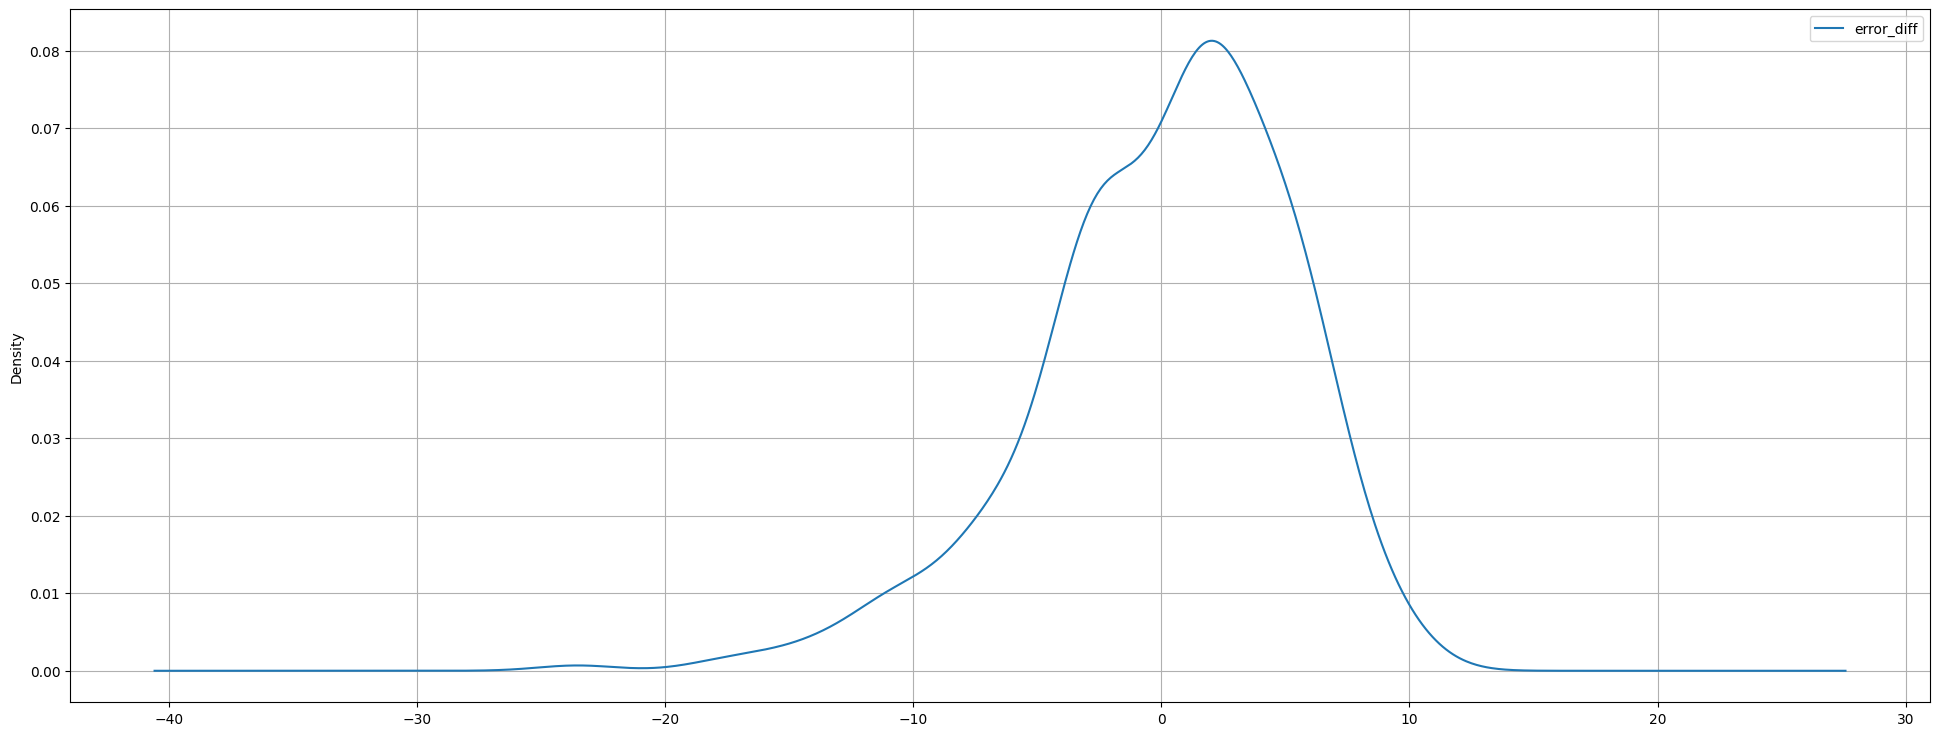

#### Item: Èaj ####
## Train & valid scores: 
WMAPE: 45.04
Bias: 3.99
## Test scores: 
WMAPE: 44.06
Bias: 19.36


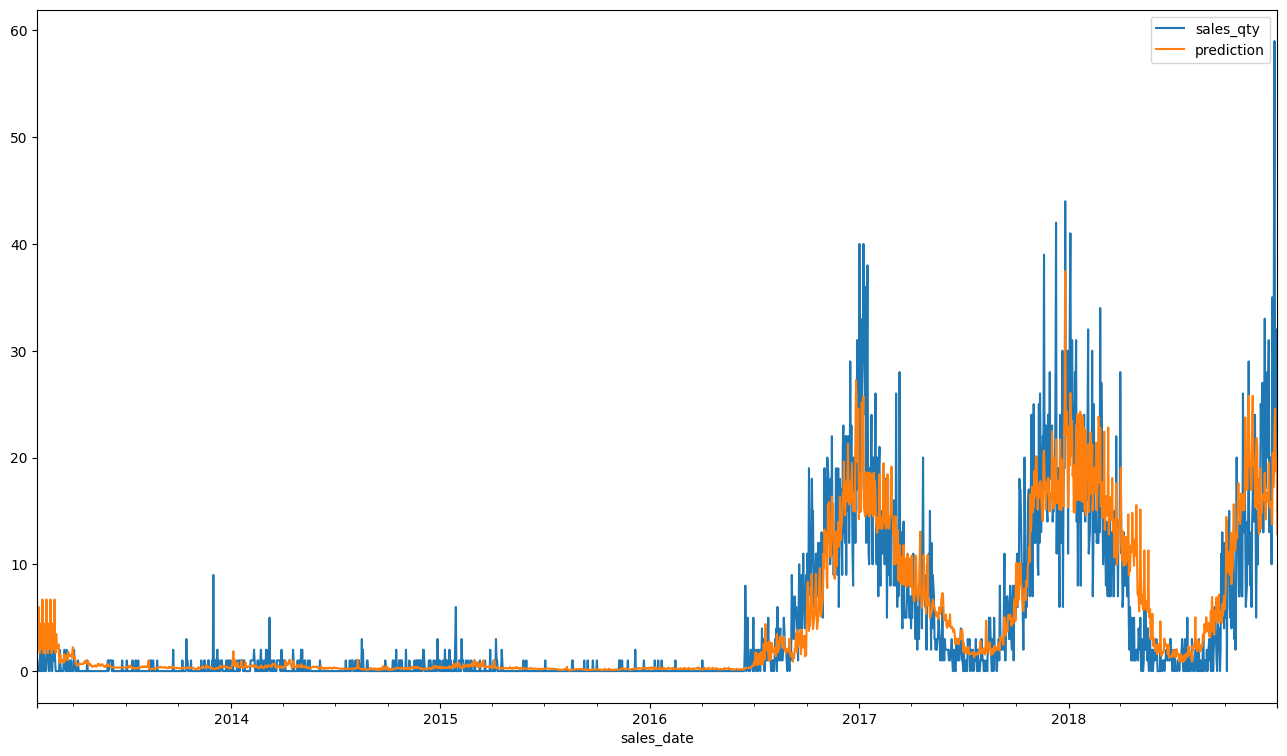

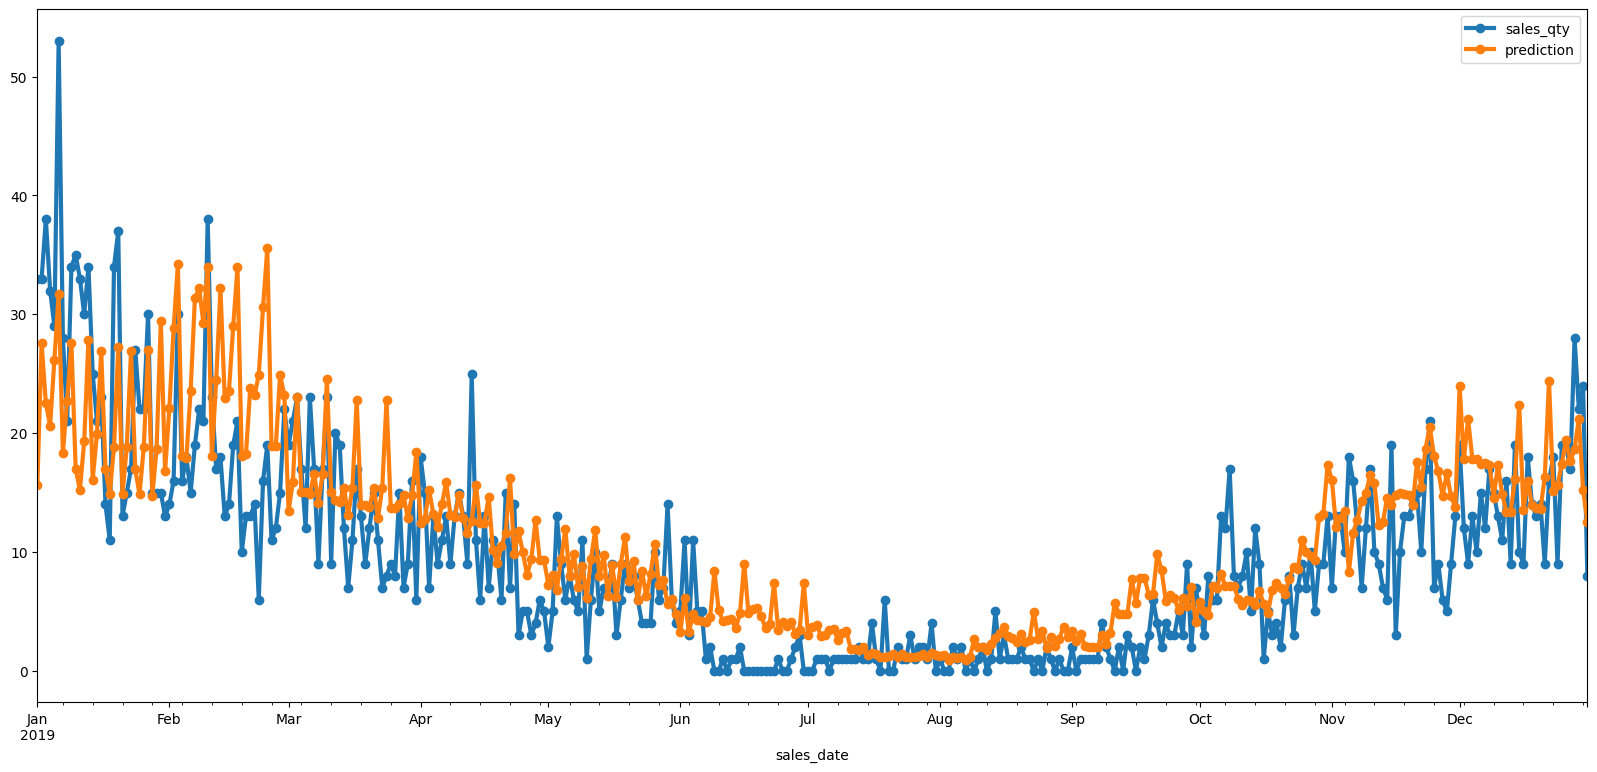

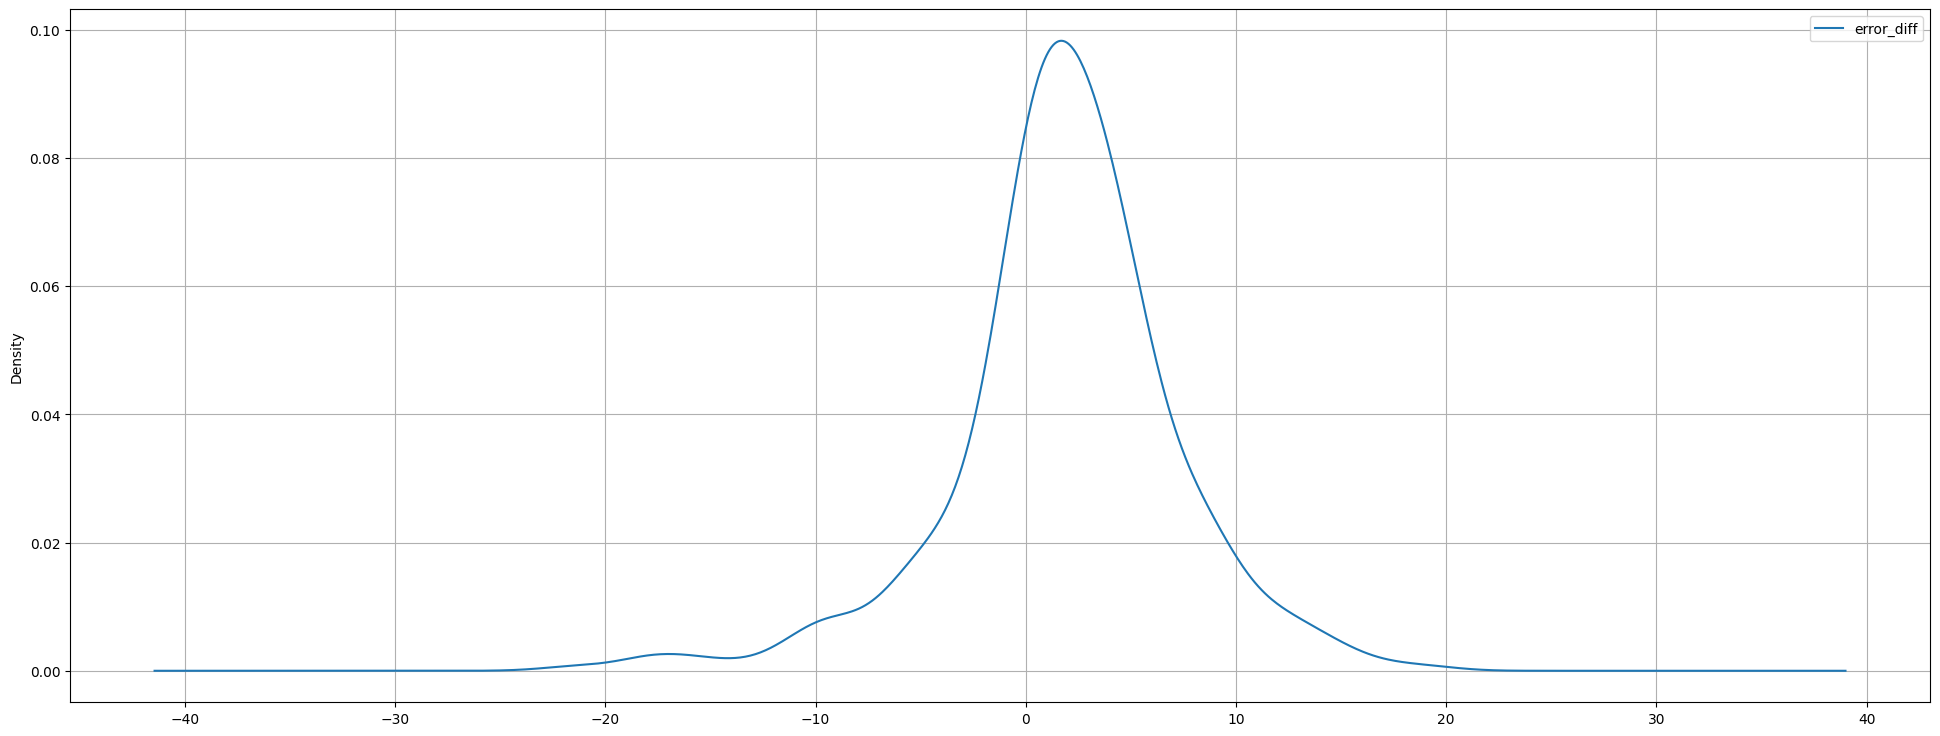

#### Item: Budweiser ####
## Train & valid scores: 
WMAPE: 61.55
Bias: 0.44
## Test scores: 
WMAPE: 88.22
Bias: 43.06


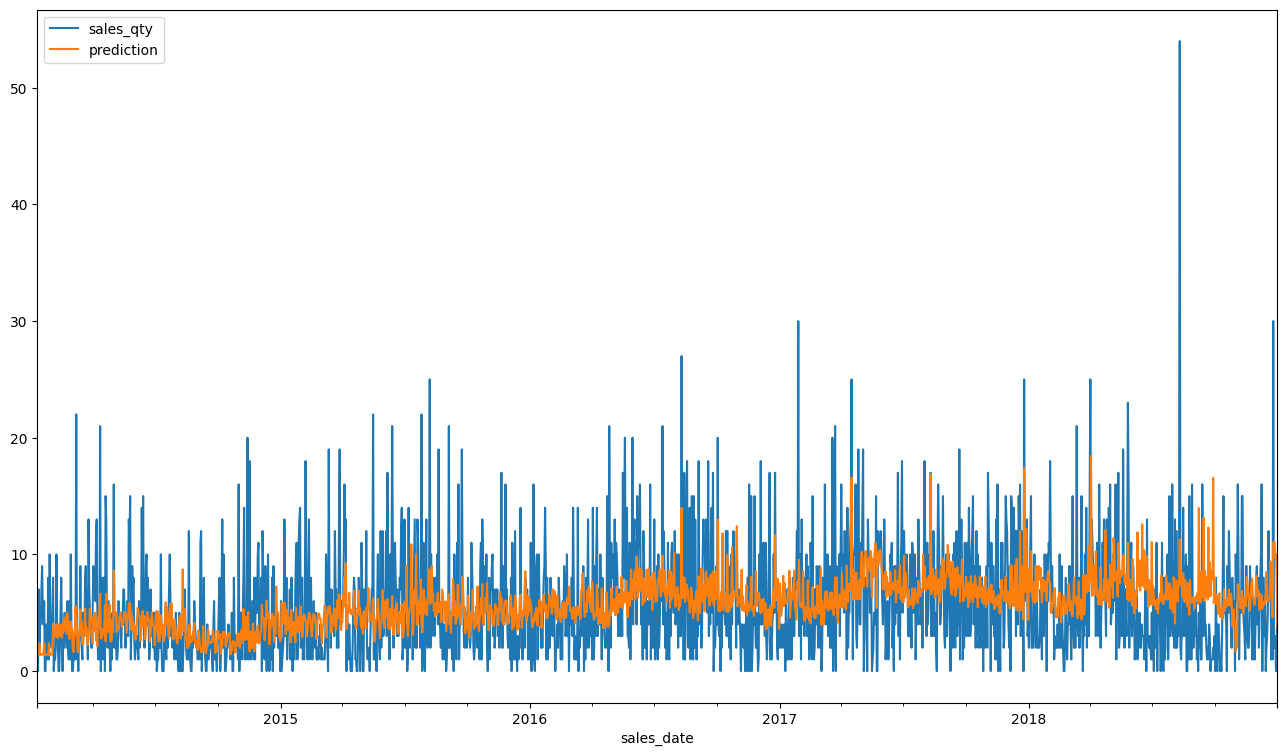

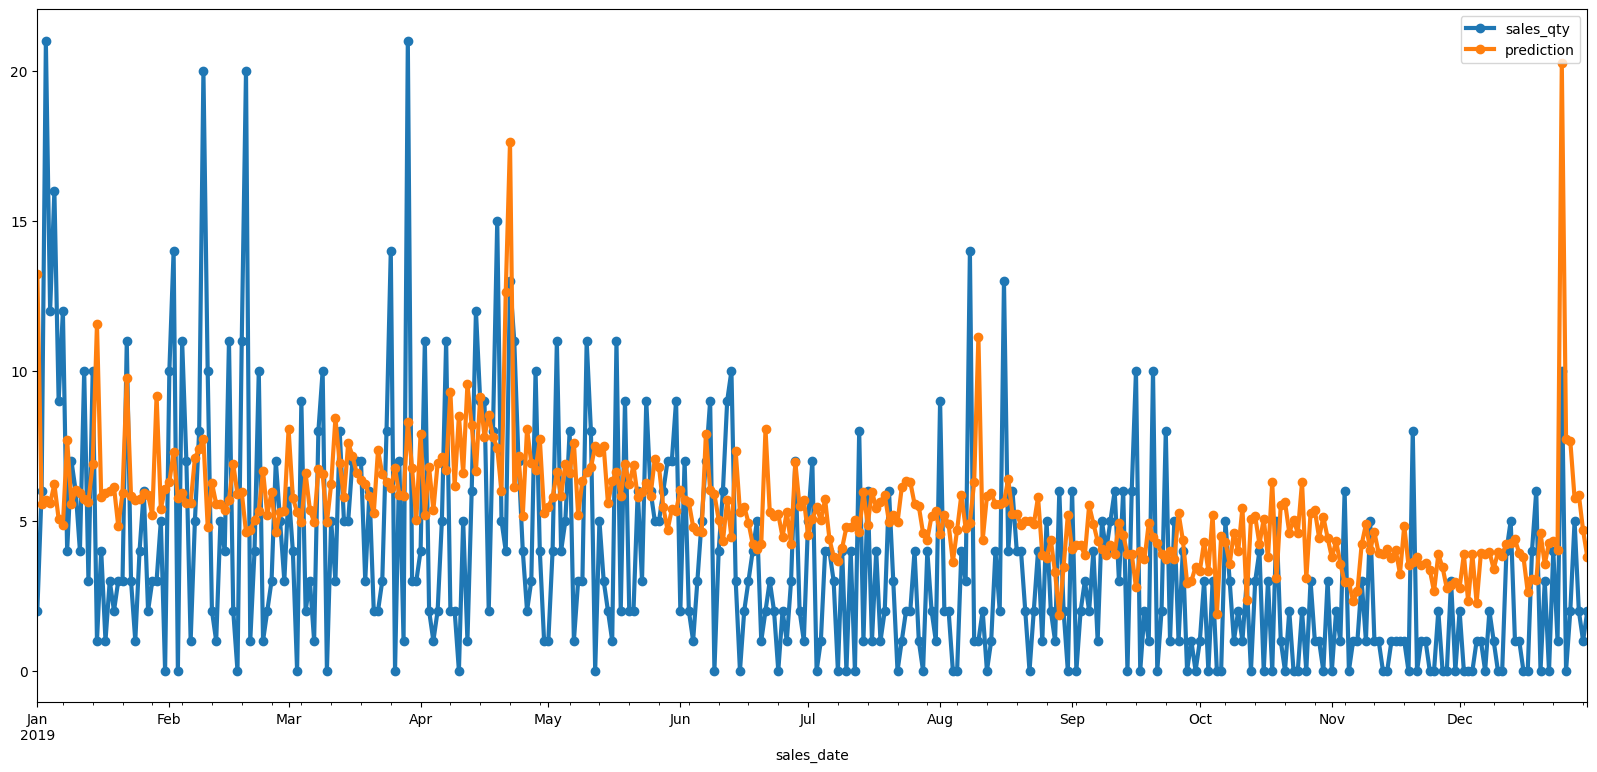

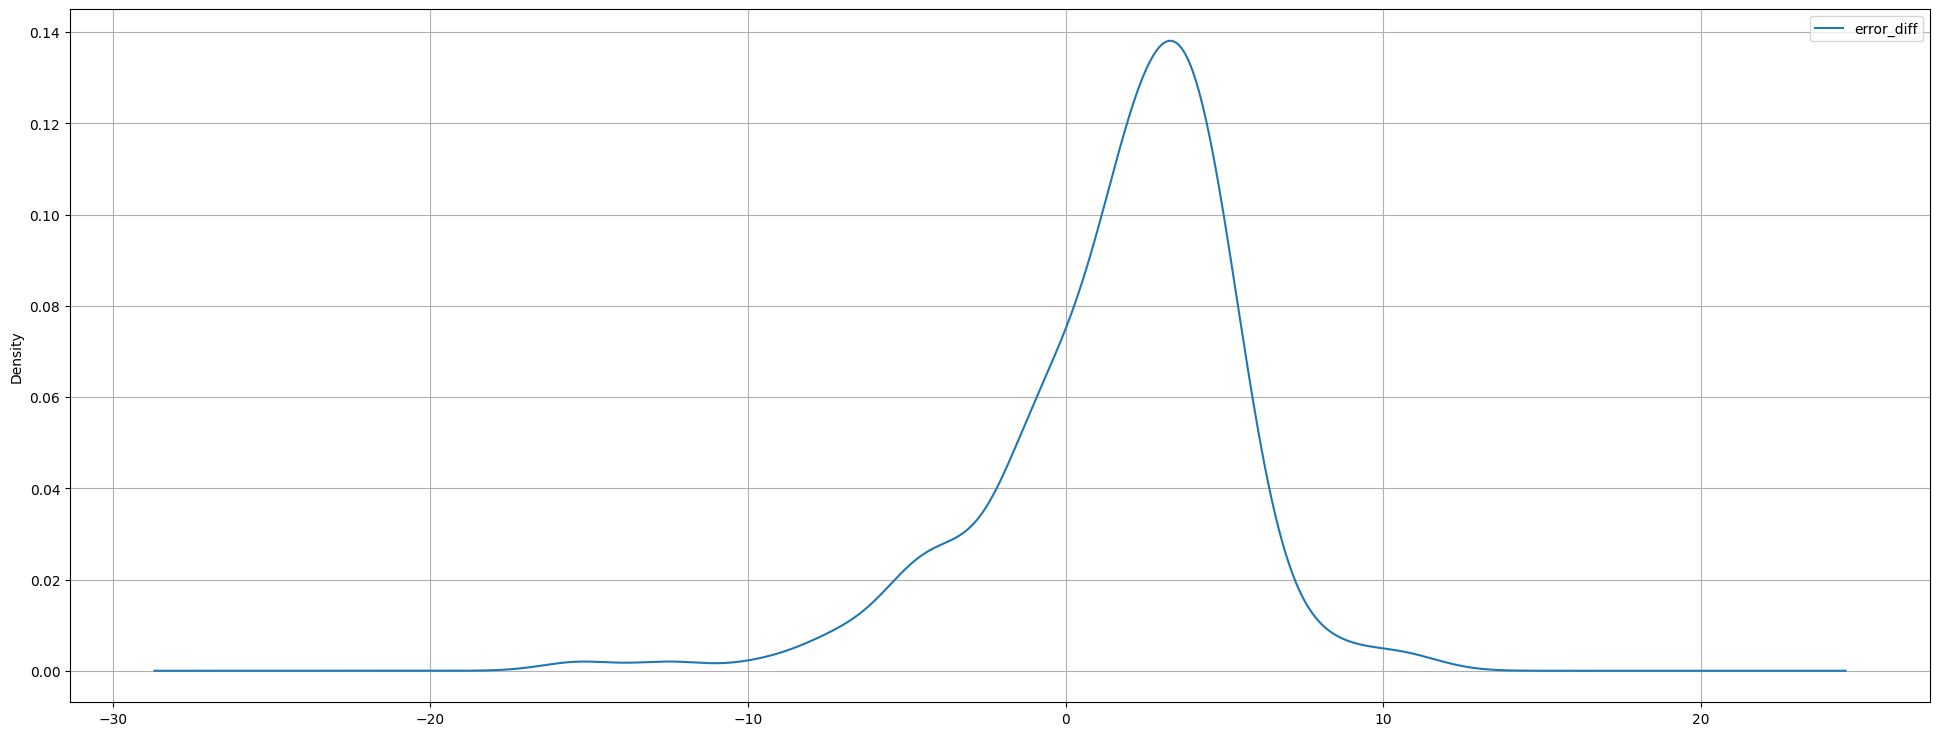

#### Item: Jamnica sensation ####
## Train & valid scores: 
WMAPE: 49.58
Bias: 8.53
## Test scores: 
WMAPE: 64.83
Bias: 12.83


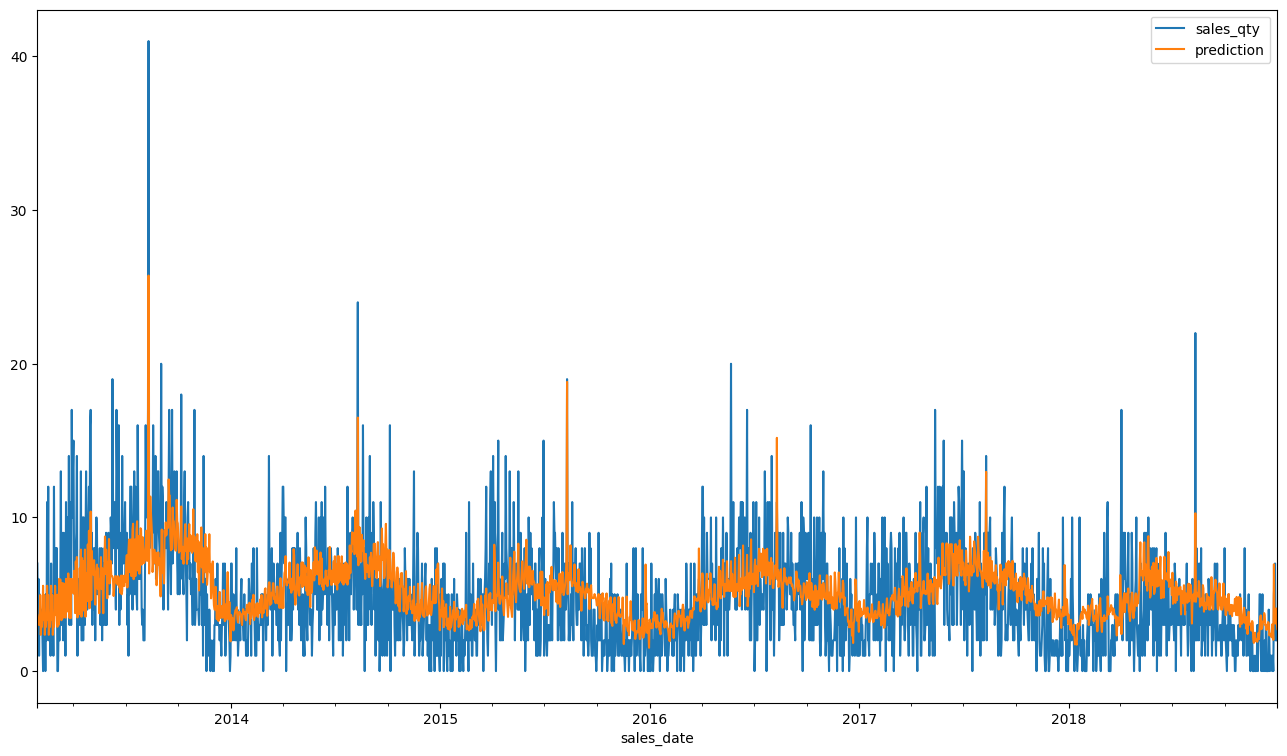

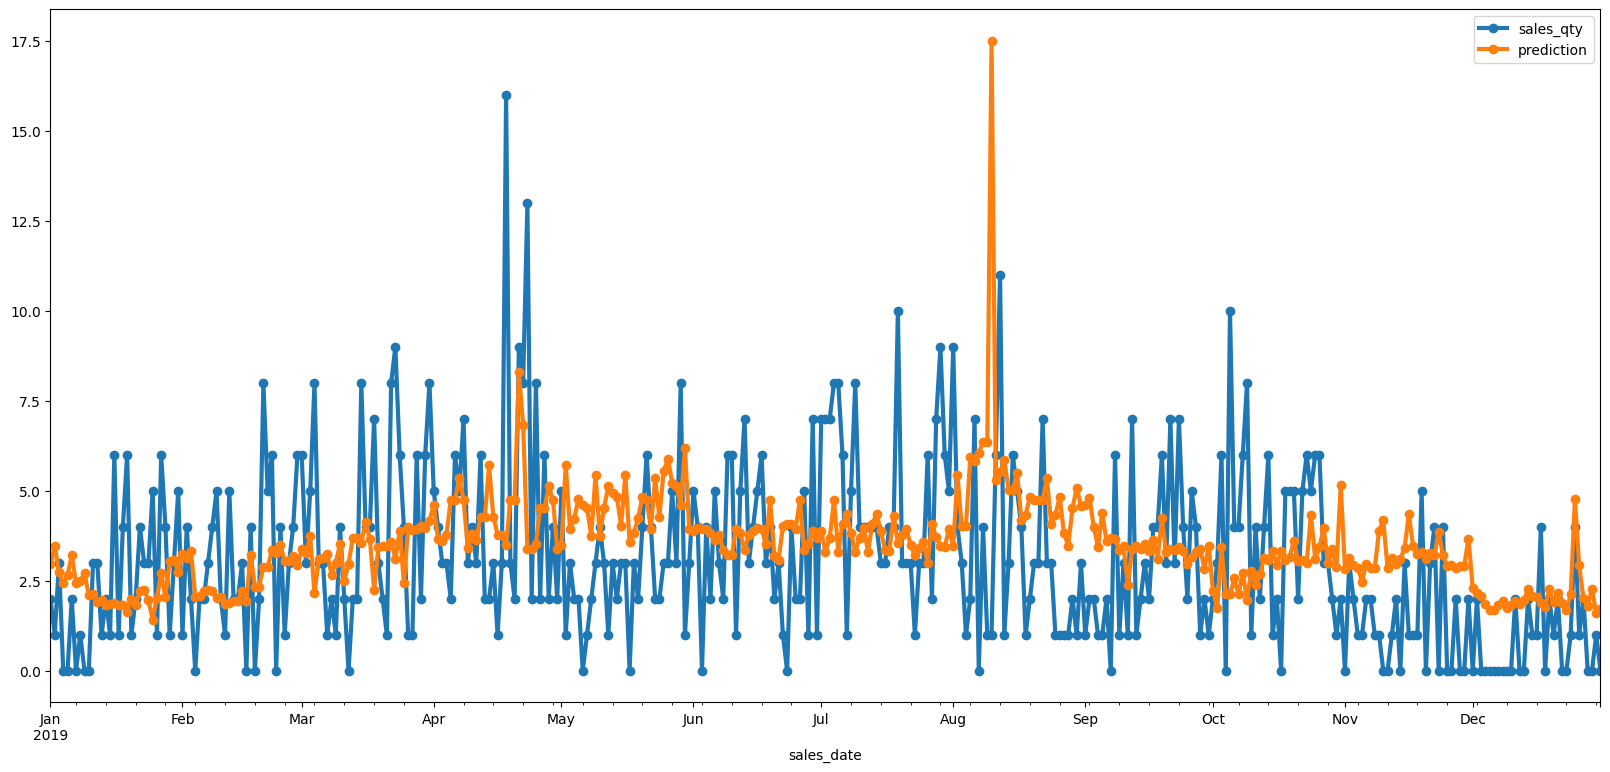

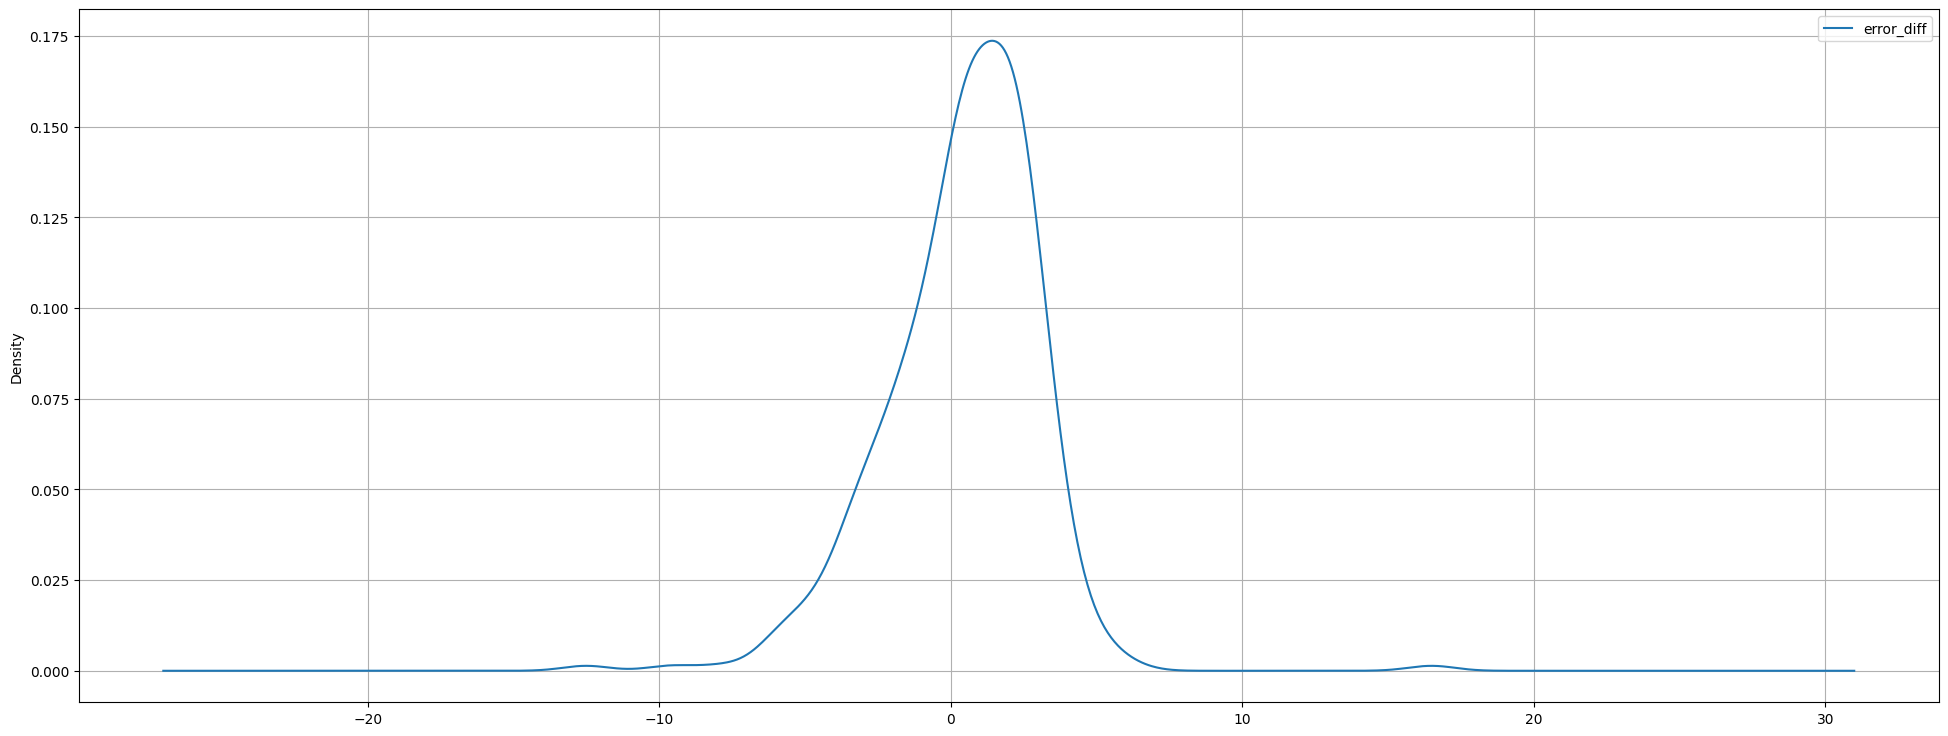

#### Item: Mineralna voda ####
## Train & valid scores: 
WMAPE: 52.21
Bias: -0.18
## Test scores: 
WMAPE: 41.85
Bias: -8.42


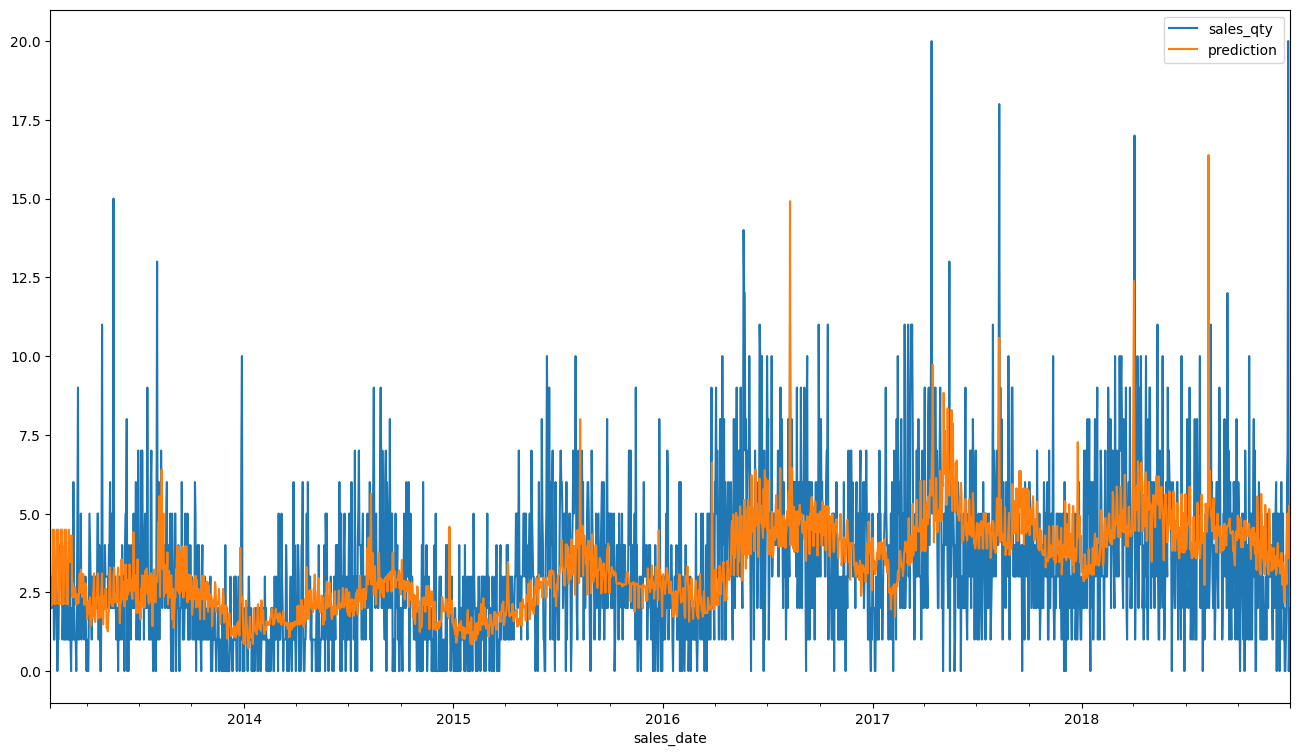

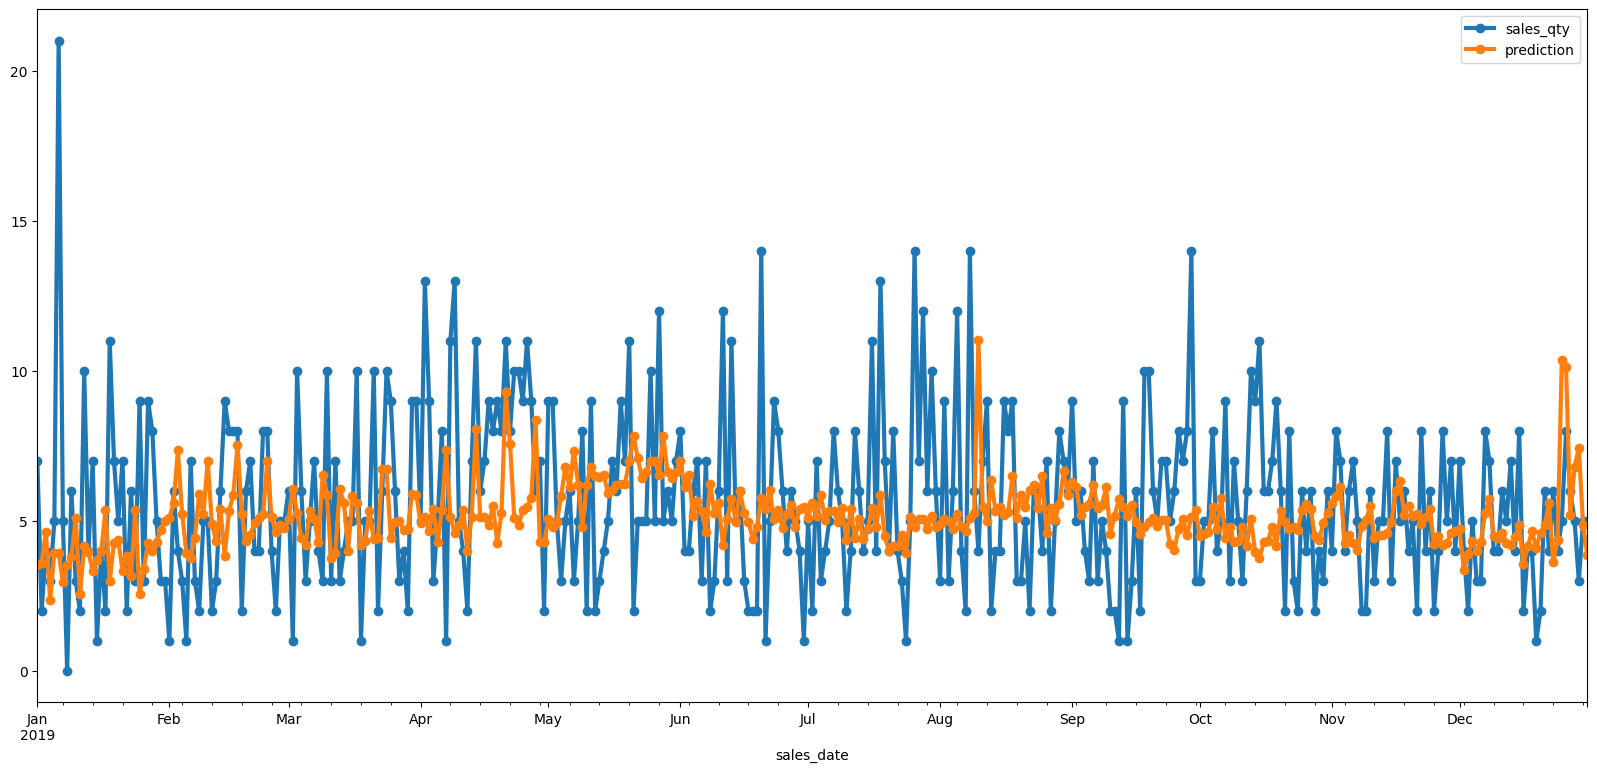

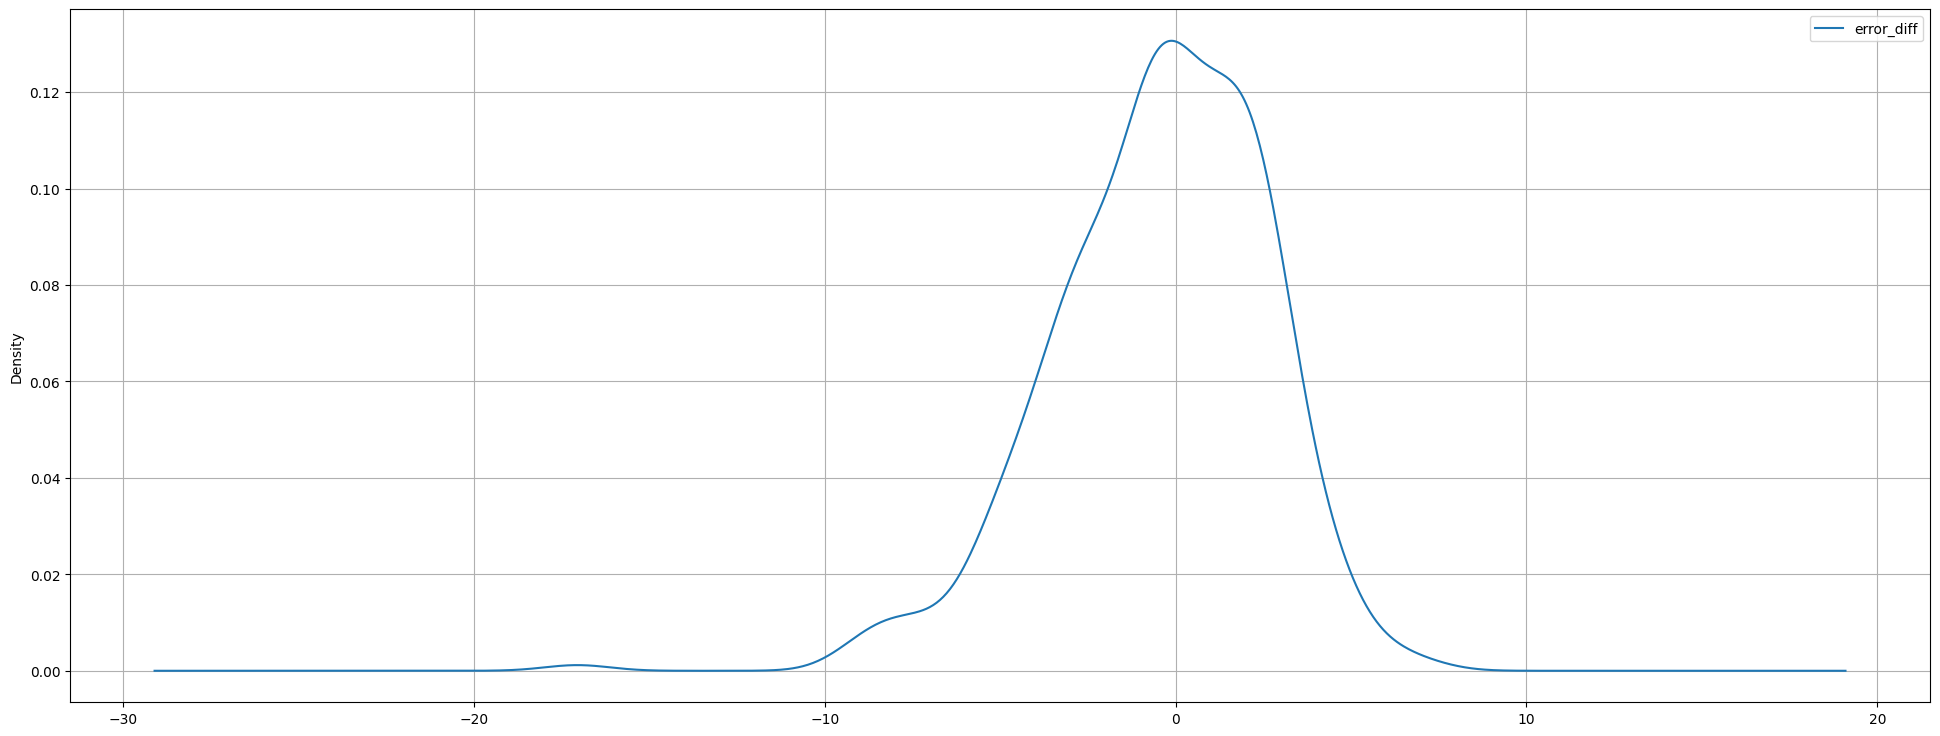

#### Item: Èaj s limunom i medom ####
## Train & valid scores: 
WMAPE: 42.27
Bias: 1.06
## Test scores: 
#### Item: Emotion ####
## Train & valid scores: 
WMAPE: 57.93
Bias: 5.35
## Test scores: 
WMAPE: 57.27
Bias: 18.79


KeyboardInterrupt: 

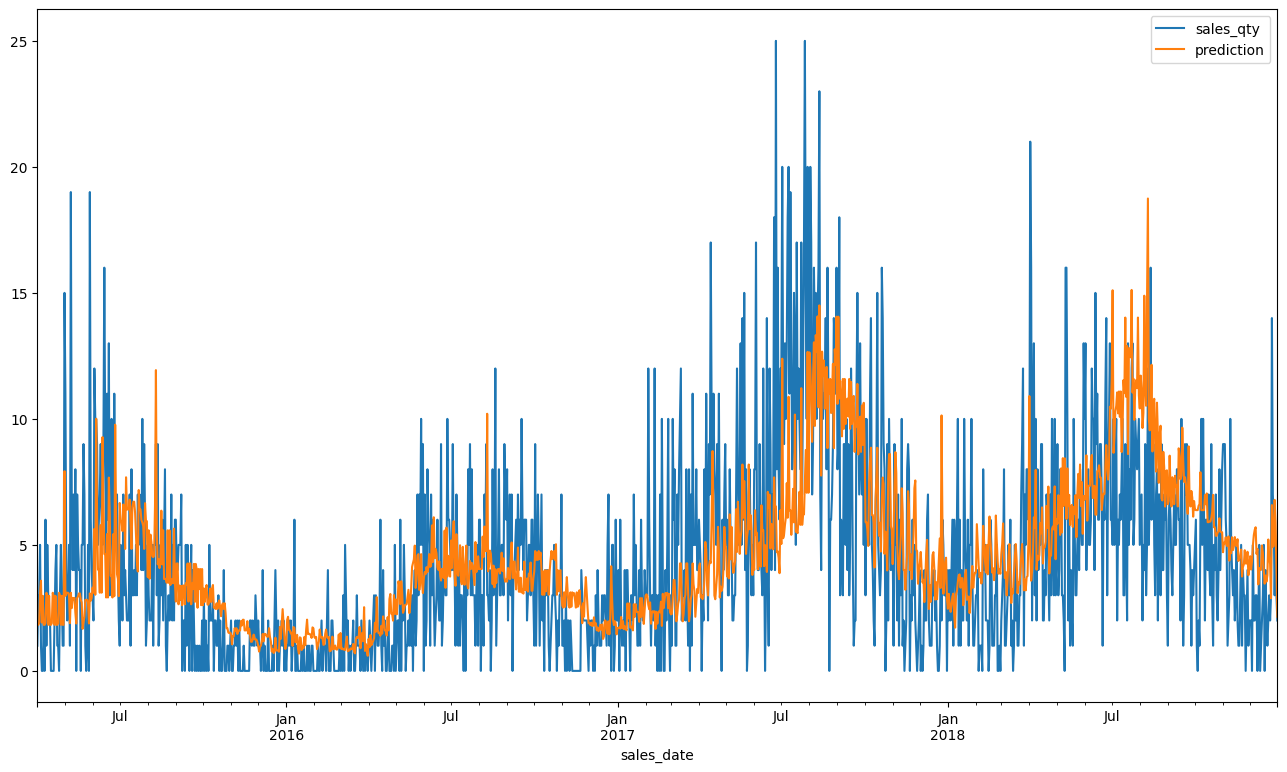

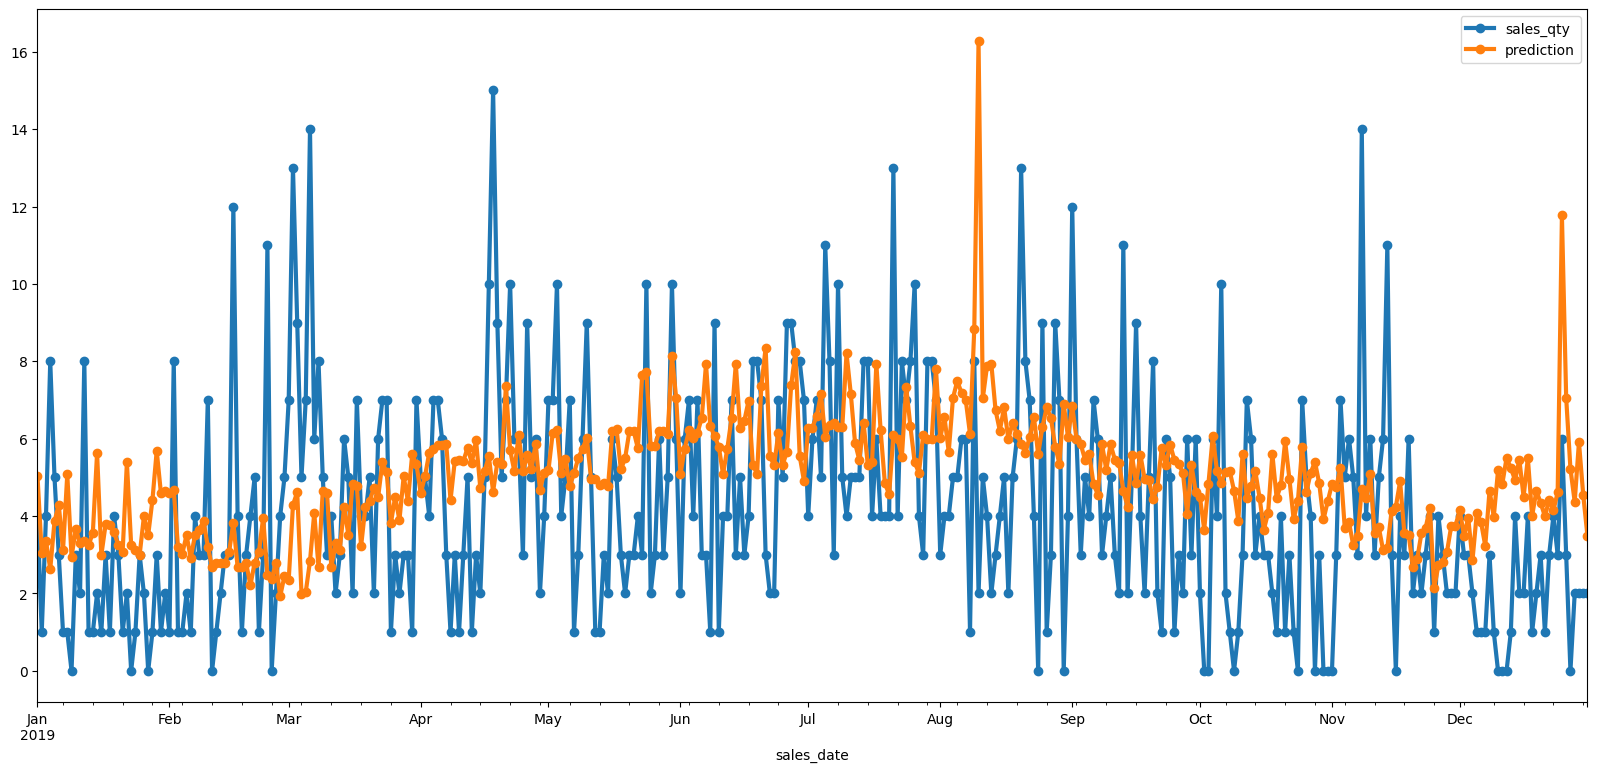

<Figure size 2400x900 with 0 Axes>

In [63]:
for item in dataset.groupby('item_name')['sales_qty'].sum().sort_values(ascending=False).index[:20]:
    print(f"#### Item: {item} ####")
    print("## Train & valid scores: ")
    print(f"WMAPE: {wmape_train_valid_scores.loc[(wmape_train_valid_scores.item_name == item), 'wmape'].values[0]}")
    print(f"Bias: {wmape_train_valid_scores.loc[(wmape_train_valid_scores.item_name == item), 'bias'].values[0]}")
    print("## Test scores: ")
    if not wmape_test_scores.loc[(wmape_test_scores.item_name == item), 'wmape'].empty:
        print(f"WMAPE: {wmape_test_scores.loc[(wmape_test_scores.item_name == item), 'wmape'].values[0]}")
        print(f"Bias: {wmape_test_scores.loc[(wmape_test_scores.item_name == item), 'bias'].values[0]}")
        dataset[(train_mask | valid_mask) & (dataset.item_name == item)].plot(y=['sales_qty', 'prediction'], figsize=(16,9))
        dataset[(test_mask) & (dataset.item_name == item)].plot(y=['sales_qty', 'prediction'], figsize=(20,9), marker='o', linewidth=3)
        dataset[(test_mask) & (dataset.item_name == item)].plot(y=['error_diff'], figsize=(24,9), kind='kde', grid=True)
        plt.show()